In [1]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from typing import Union, Tuple

In [2]:
import lightgbm

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [3]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [4]:
df.head()

date      month    quarter  feature_217  feature_66  feature_9  \
22620  2021-01-01 2021-01-01 2021-01-01     1.180855    0.483118  13.976791   
478621 2021-01-01 2021-01-01 2021-01-01     3.427814    0.886778  27.158209   
372254 2021-01-01 2021-01-01 2021-01-01   -38.555018    1.227175  19.893873   
2596   2021-01-01 2021-01-01 2021-01-01   -14.666558    0.753129  18.203010   
216892 2021-01-01 2021-01-01 2021-01-01     6.734990    1.129100  11.245920   

        feature_193  feature_15  feature_199  feature_25  ...  feature_20  \
22620      1.135021   43.271792   -46.888875   97.558366  ...   23.745198   
478621    -0.378728   80.087863   -67.242703  105.803406  ...   22.902111   
372254     0.498787   98.464365   -67.402522   81.858076  ...   21.848414   
2596      -1.200014  117.331340   -25.557745   90.277266  ...   26.134586   
216892    -0.108955   61.205722   -78.397406   82.637472  ...   24.201039   

        feature_188  feature_71  feature_106  feature_14  feature_92  \
22620    -32.001093   85.489903     1.454045 -195.725786    3.719083   
478621   -37.436243   71.735619     1.657242 -176.250404    3.277817   
372254   -51.872841   65.363236     1.626874 -178.116798    2.028950   
2596     -49.703003   65.013659     1.170023 -192.232264    2.218177   
216892   -41.070219   69.986127     1.630795 -200.155528    3.055104   

        feature_179  feature_102  target  sample_part  
22620             1   -28.813537     0.0        train  
478621            1   -45.987721     1.0        train  
372254            0   -31.074122     1.0        train  
2596              1   -36.703897     0.0        train  
216892            1   -44.672299     1.0        train  

[5 rows x 235 columns]

In [5]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique`

In [6]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets


from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

from scipy.stats import norm
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    alpha = 0.05 #95% интервал
    sum_target_zeros = np.bincount(buckets, weights=(target == 0))
    sum_target_ones = np.bincount(buckets, weights=(target == 1))
    badrate = sum_target_ones / (sum_target_zeros + sum_target_ones)
    badrate[badrate == 0] = 0.001
    badrate[badrate == 1] = 0.999
    se = np.sqrt(badrate * (1 - badrate) / (sum_target_zeros + sum_target_ones))
    z = norm.ppf(1 - alpha / 2)
    badrate_lower = np.where(badrate - z * se > 0, badrate - z * se, 0.001)
    badrate_upper = np.where(badrate + z * se < 1, badrate + z * se, 0.999)
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    #badrate, badrate_lower, badrate_upper = None, None, None

    # переходим от бэдрейта к woe
    #woe, woe_lower, woe_upper = None, None, None

    return woe, woe_lower, woe_upper

from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    logreg = LogisticRegression()
    logreg.fit(values.reshape(-1, 1), target)
    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    proba = logreg.predict_proba(mean_feature.reshape(-1, 1))[:, 1]
    line = woe_transform(proba, offset)
    return line

def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    offset = logit(np.sum(target)/target.shape[0])
    mean_feature = np.zeros(np.unique(buckets).shape)
    for i, bucket_value in enumerate(np.unique(buckets)):
        mean_feature[i] = np.mean(values[buckets == bucket_value])
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values, target, mean_feature, offset),
        "woe"          : woe_ci(target, buckets, offset)[0],
        "woe_lower"    : woe_ci(target, buckets, offset)[1],
        "woe_upper"    : woe_ci(target, buckets, offset)[2]
    }

    return buckets_info


from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score(target, values)


    # формула выше
    sum_target_zeros = np.bincount(buckets, weights=(target == 0))
    sum_target_ones = np.bincount(buckets, weights=(target == 1))
    badrate = sum_target_ones / (sum_target_zeros + sum_target_ones)
    badrate[badrate == 0] = 0.001
    badrate[badrate == 1] = 0.999
    offset = logit(np.sum(target)/target.shape[0])
    woe = woe_transform(badrate, offset)


    IV = np.sum((sum_target_ones / np.sum(target) - sum_target_zeros / (target.shape[0] - np.sum(target))) * woe)

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    info = calc_buckets_info(values, target, buckets)
    R_sqr = r2_score(info['woe'], info['line'], sample_weight = np.unique(buckets, return_counts = True)[1])

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return IV

In [7]:
non_numeric = []
for i in range(len(features)):
  if df[features[i]].nunique() <= 60:
    non_numeric.append(features[i])

In [8]:
numeric_features = [x for x in features if x not in non_numeric]

In [9]:
IV_values = []
for feature in numeric_features:
  missing = np.where(df[feature].isna())[0]
  IV = calc_plot_title(df[feature].dropna().to_numpy(), df['target'].drop(missing).to_numpy(), calc_buckets(df[feature].drop(missing).to_numpy(), 20))
  IV_values.append(IV)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site

In [10]:
feature_IVs = {key: value for key, value in zip(numeric_features, IV_values)}

In [11]:
filtered_df = df
features_to_drop = []
for feature, IV_value in feature_IVs.items():
    if IV_value < 0.005:
        features_to_drop.append(feature)
filtered_df = filtered_df.drop(columns=features_to_drop)

In [12]:
filtered_df.columns

Index(['date', 'month', 'quarter', 'feature_9', 'feature_15', 'feature_154',
       'feature_218', 'feature_96', 'feature_223', 'feature_30', 'feature_225',
       'feature_162', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_167', 'feature_109', 'feature_124',
       'feature_79', 'feature_213', 'feature_117', 'feature_38', 'feature_24',
       'feature_10', 'feature_75', 'feature_5', 'feature_56', 'feature_114',
       'feature_139', 'feature_142', 'feature_31', 'feature_12', 'feature_35',
       'feature_227', 'feature_115', 'feature_155', 'feature_132',
       'feature_76', 'feature_97', 'feature_140', 'feature_135', 'feature_26',
       'feature_0', 'feature_2', 'feature_46', 'feature_100', 'feature_111',
       'feature_164', 'feature_161', 'feature_98', 'feature_36', 'feature_209',
       'feature_183', 'feature_27', 'feature_4', 'feature_32', 'feature_62',
       'feature_206', 'feature_172', 'feature_70', 'feature_44', 'feature_23',
       'feature

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

В силу дискретности распределения категориальных фичей, их IV должен быть значительно ниже

In [13]:
cat_dtypes = []
for i in non_numeric:
  cat_dtypes.append(df[i].dtype)
cat_dtypes

[CategoricalDtype(categories=['a', 'b', 'c', 'd'], ordered=True, categories_dtype=object),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 CategoricalDtype(categories=['UNEMP', 'GVM', 'PRIV'], ordered=True, categories_dtype=object),
 dtype('int64')]

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for idx in [0, -2]:
    column_name = non_numeric[idx]
    df[column_name] = label_encoder.fit_transform(df[column_name])


In [15]:
IV_cat_values = []
for feature in non_numeric:
  missing = np.where(df[feature].isna())[0]
  IV = calc_plot_title(df[feature].dropna().to_numpy(), df['target'].drop(missing).to_numpy(), calc_buckets(df[feature].drop(missing).to_numpy(), min(20, df[feature].dropna().nunique())))
  IV_cat_values.append(IV)

cat_feature_IVs = {key: value for key, value in zip(non_numeric, IV_cat_values)}
cat_features_to_drop = []
for feature, IV_value in cat_feature_IVs.items():
    if IV_value < 0.0009:
        cat_features_to_drop.append(feature)
filtered_df = filtered_df.drop(columns=cat_features_to_drop)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [16]:
filtered_df.columns

Index(['date', 'month', 'quarter', 'feature_9', 'feature_15', 'feature_154',
       'feature_218', 'feature_96', 'feature_223', 'feature_30', 'feature_225',
       'feature_162', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_167', 'feature_109', 'feature_124',
       'feature_79', 'feature_213', 'feature_117', 'feature_38', 'feature_24',
       'feature_10', 'feature_75', 'feature_5', 'feature_56', 'feature_114',
       'feature_139', 'feature_142', 'feature_31', 'feature_12', 'feature_35',
       'feature_227', 'feature_115', 'feature_155', 'feature_132',
       'feature_76', 'feature_97', 'feature_140', 'feature_135', 'feature_26',
       'feature_2', 'feature_46', 'feature_100', 'feature_111', 'feature_164',
       'feature_161', 'feature_98', 'feature_36', 'feature_209', 'feature_183',
       'feature_27', 'feature_4', 'feature_32', 'feature_62', 'feature_206',
       'feature_172', 'feature_70', 'feature_44', 'feature_23', 'feature_170',
       'featu

# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [17]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = [f'feature_{i}' for i in range(N_FEATURES) if f'feature_{i}' in filtered_df.columns]

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [ ]:
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
#         'n_jobs': -1,
#         'random_state': 42
#     }

#     clf = LGBMClassifier(**params)
#     clf.fit(
#         X=df.loc[df['sample_part'] == 'train', features_optuna],
#         y=df.loc[df['sample_part'] == 'train', TARGET]
#     )
#     preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
#     auc_valid = roc_auc_score(
#         y_true=df.loc[df['sample_part'] == 'val', TARGET],
#         y_score=preds
#     )

#     return auc_valid

In [ ]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=60)

In [18]:
best_params =  { #перезапускал ядро, сохранил параметры, подобранные оптуной
    'learning_rate': 0.09818983307595966,
    'num_leaves': 150,
    'max_depth': 9,
    'min_child_samples': 90,
    'subsample': 0.7685890730013264,
    'colsample_bytree': 0.9380192014468047,
    'reg_alpha': 8.965716599102121,
    'reg_lambda': 7.181326555592763,
    'n_estimators': 747,
    'n_jobs': -1,
    'random_state': 42
              }

In [19]:
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [20]:
auc_test

0.7376131072208685

## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`.

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

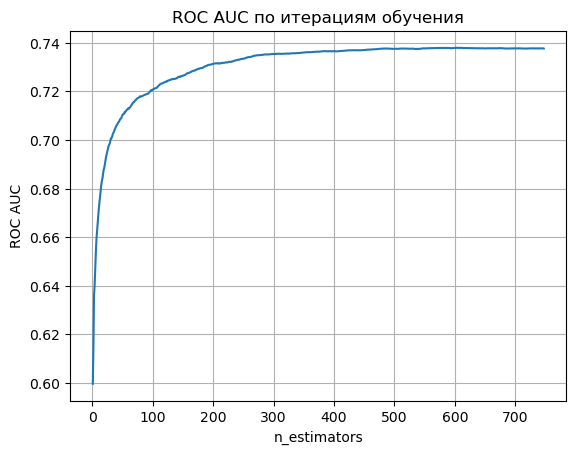

In [21]:
roc_auc_list = {}
X_train = df.loc[df['sample_part'] == 'train', features_optuna]
y_train = df.loc[df['sample_part'] == 'train', TARGET]
X_test = df.loc[df['sample_part'] == 'test', features_optuna]
y_test = df.loc[df['sample_part'] == 'test', TARGET]
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lightgbm.record_evaluation(roc_auc_list)]
)
values = list(roc_auc_list.values())[0]['auc']
n_estimators = range(1, len(values) + 1)
plt.plot(n_estimators, values)
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
plt.title('ROC AUC по итерациям обучения')
plt.grid(True)
plt.show()

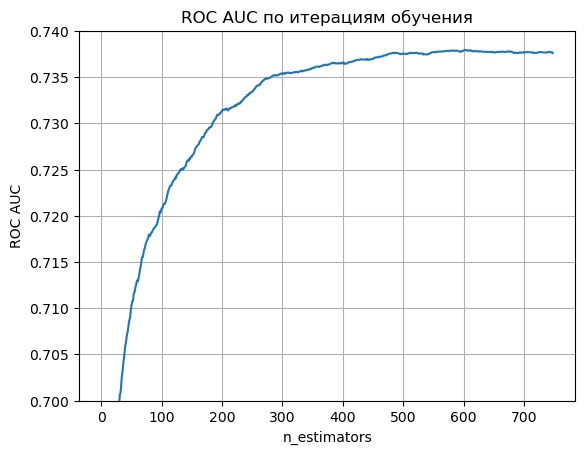

In [22]:
plt.plot(n_estimators, values)
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
plt.title('ROC AUC по итерациям обучения')
plt.grid(True)
plt.ylim(0.7, 0.74)
plt.show()

In [23]:
max(values)
values.index(max(values))

603

**Вопрос:** Что вы видите на полученных графиках?

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

Видим, что аук начинает потихоньку падать после 603-го дерева, поэтому можем обрезать количество деревьев.

In [24]:
best_params =  {
    'learning_rate': 0.09818983307595966,
    'num_leaves': 150,
    'max_depth': 9,
    'min_child_samples': 90,
    'subsample': 0.7685890730013264,
    'colsample_bytree': 0.9380192014468047,
    'reg_alpha': 8.965716599102121,
    'reg_lambda': 7.181326555592763,
    'n_estimators': 603,
    'n_jobs': -1,
    'random_state': 42
              }
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(colsample_bytree=0.9380192014468047,
               learning_rate=0.09818983307595966, max_depth=9,
               min_child_samples=90, n_estimators=603, n_jobs=-1,
               num_leaves=150, random_state=42, reg_alpha=8.965716599102121,
               reg_lambda=7.181326555592763, subsample=0.7685890730013264)

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

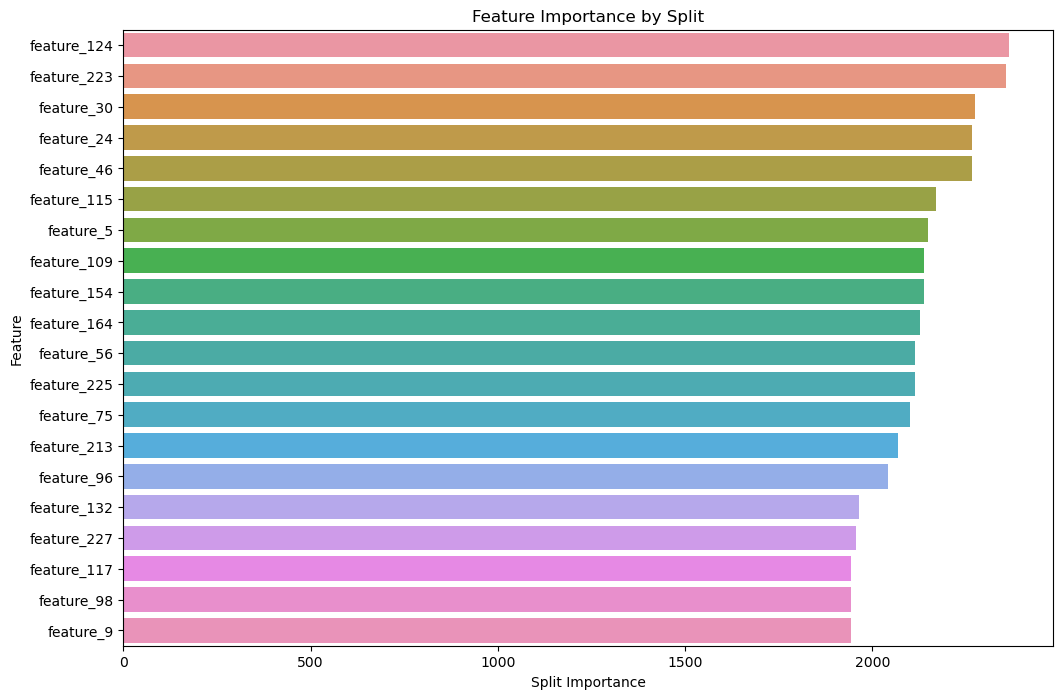

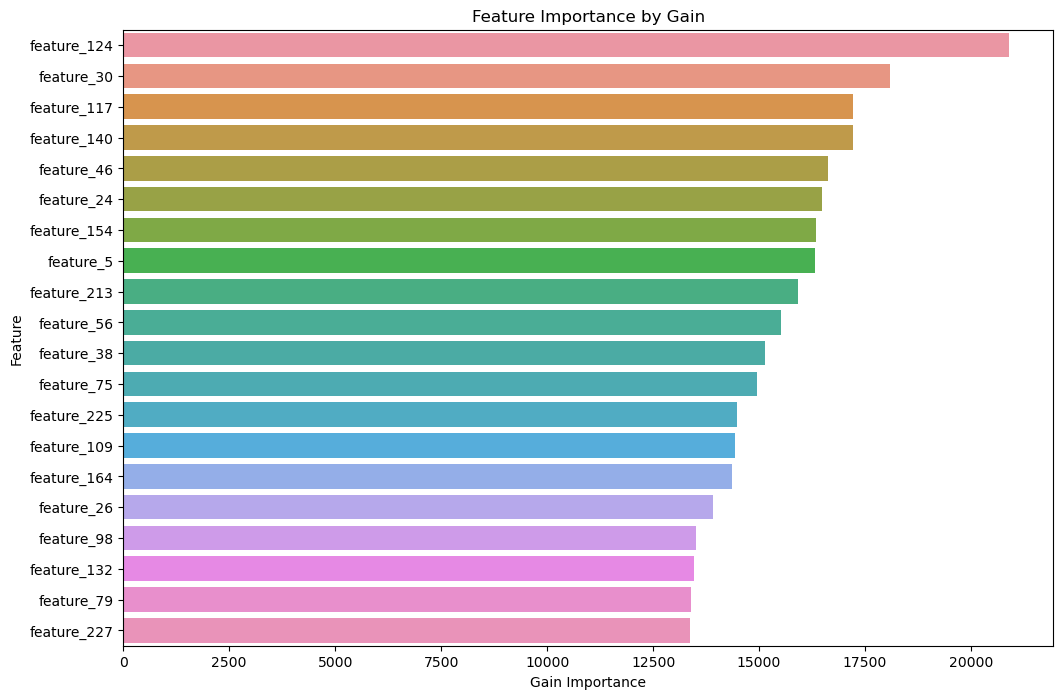

In [25]:
split_importances = clf.feature_importances_
gain_importances = clf.booster_.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': features_optuna,
    'Split Importance': split_importances,
    'Gain Importance': gain_importances
})
sorted_importance_df_split = importance_df.sort_values(by='Split Importance', ascending=False)
sorted_importance_df_gain = importance_df.sort_values(by='Gain Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Split Importance', y='Feature', data=sorted_importance_df_split.head(20))
plt.title('Feature Importance by Split')
plt.xlabel('Split Importance')
plt.ylabel('Feature')
plt.show()
plt.figure(figsize=(12, 8))
sns.barplot(x='Gain Importance', y='Feature', data=sorted_importance_df_gain.head(20))
plt.title('Feature Importance by Gain')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

Топы признаков по сплиту и по гейну в целом схожи, хотя и заметны некоторые различия. По сплиту распределение важностей более равномерное, чем по гейну, где топ-фичи заметно опережают остальные. Можно сделать предположение о скоррелированности некоторых фичей в силу совсем уж разных позиций в топе, что может говорить о том, что импортанс по сплитам размазался

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно:
- массив значений фичи,
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [26]:
import plotly.graph_objects as go

In [220]:
def calc_IV_and_auc(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score(target, values)


    # формула выше
    sum_target_zeros = np.bincount(buckets, weights=(target == 0))
    sum_target_ones = np.bincount(buckets, weights=(target == 1))
    badrate = sum_target_ones / (sum_target_zeros + sum_target_ones)
    badrate[badrate == 0] = 0.001
    badrate[badrate == 1] = 0.999
    offset = logit(np.sum(target)/target.shape[0])
    woe = woe_transform(badrate, offset)


    IV = np.sum((sum_target_ones / np.sum(target) - sum_target_zeros / (target.shape[0] - np.sum(target))) * woe)

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    info = calc_buckets_info(values, target, buckets)
    R_sqr = r2_score(info['woe'], info['line'], sample_weight = np.unique(buckets, return_counts = True)[1])

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return IV, auc


def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    df = pd.DataFrame({
    'feature': values,
    'time': time,
    'target': target
    })
    flag = 0
    if metric == 'IV':
      flag = 1
      IV_values = []
      for time_value in df['time'].unique():
        filtered_df = df[df['time'] == time_value].reset_index(drop=True)
        feature_data = filtered_df['feature'].dropna().to_numpy()
        missing_indices = np.where(filtered_df['feature'].isna())[0]
        target_data = filtered_df['target'].drop(missing_indices).to_numpy()
        IV = calc_IV_and_auc(feature_data, target_data, calc_buckets(feature_data, min(n_buckets_for_IV, df['feature'].nunique())))[0]
        IV_values.append(IV)
    elif metric == 'roc_auc':
      auc_values = []
      for time_value in df['time'].unique():
        filtered_df = df[df['time'] == time_value].reset_index(drop=True)
        feature_data = filtered_df['feature'].dropna().to_numpy()
        missing_indices = np.where(filtered_df['feature'].isna())[0]
        target_data = filtered_df['target'].drop(missing_indices).to_numpy()
        auc = calc_IV_and_auc(feature_data, target_data, calc_buckets(feature_data, min(n_buckets_for_IV, df['feature'].nunique())))[1]
        auc_values.append(auc)
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")



    plot_title = f"{values.name} and IV in time" if flag == 1 else f"{values.name} and AUC in time"
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= [time_value for time_value in df['time'].unique()], # месяцы или кварталы, your code here
            y= IV_values if flag == 1 else auc_values, # аггрегированное значение метрики, your code here
            mode='markers+lines',
            name= f"{values.name}"# имя фичи, your code here
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals= [time_value for time_value in df['time'].unique()]# месяцы или кварталы, your code here
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [28]:
top_gain = importance_df.sort_values(by='Gain Importance', ascending=False)[:15]
top_gain_features = top_gain['Feature'].to_list()

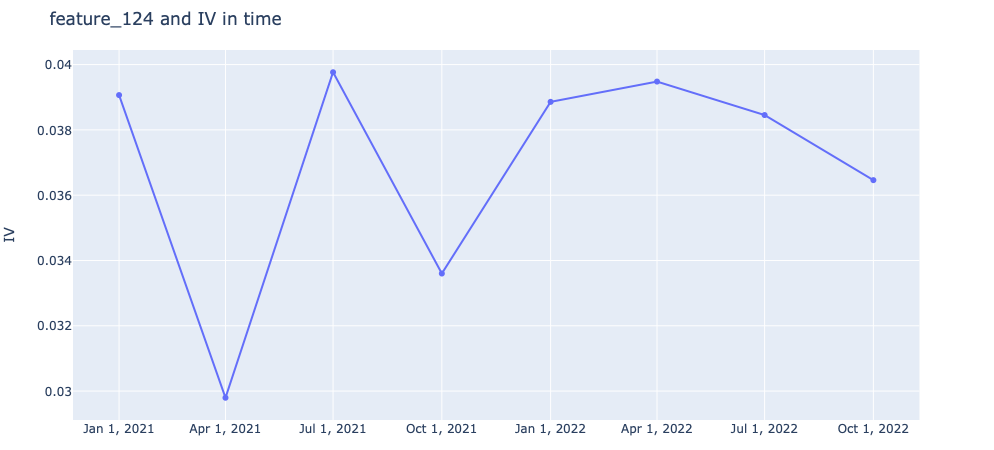

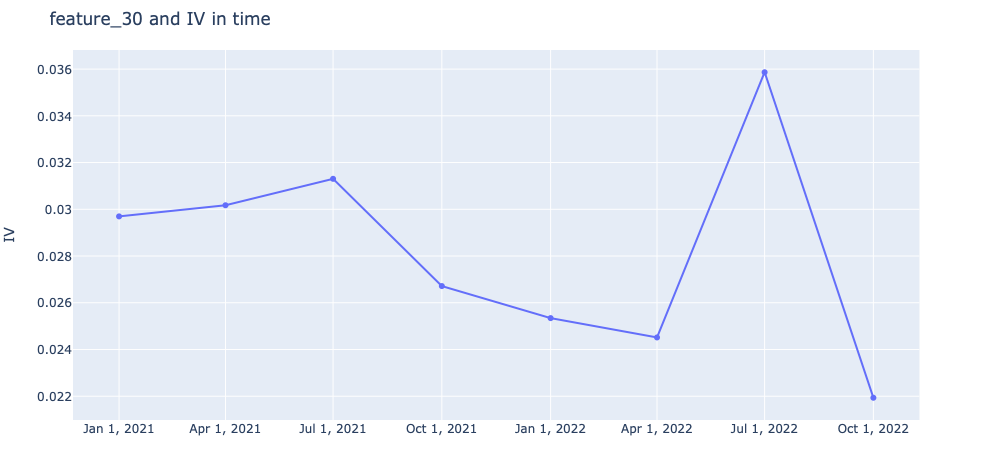

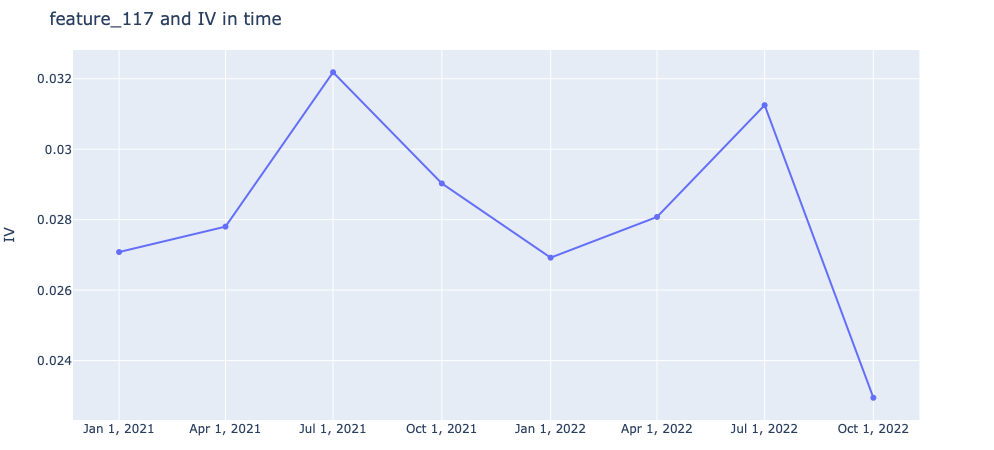

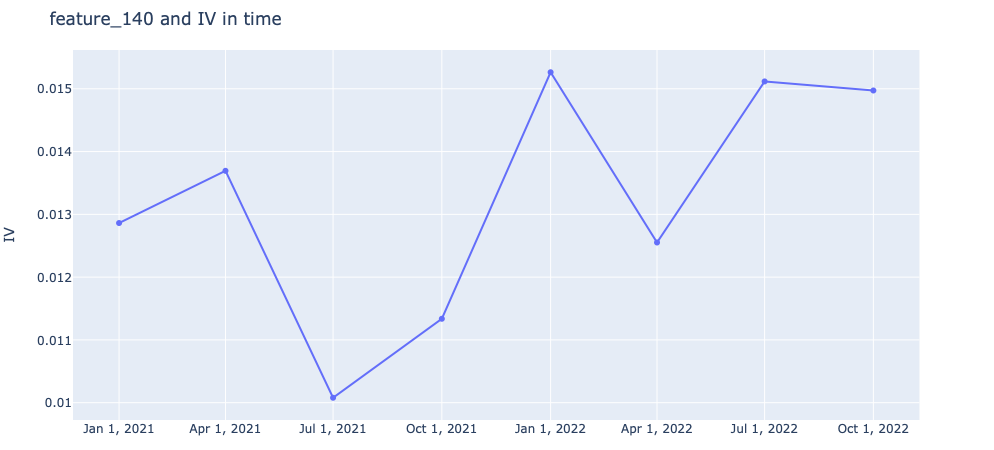

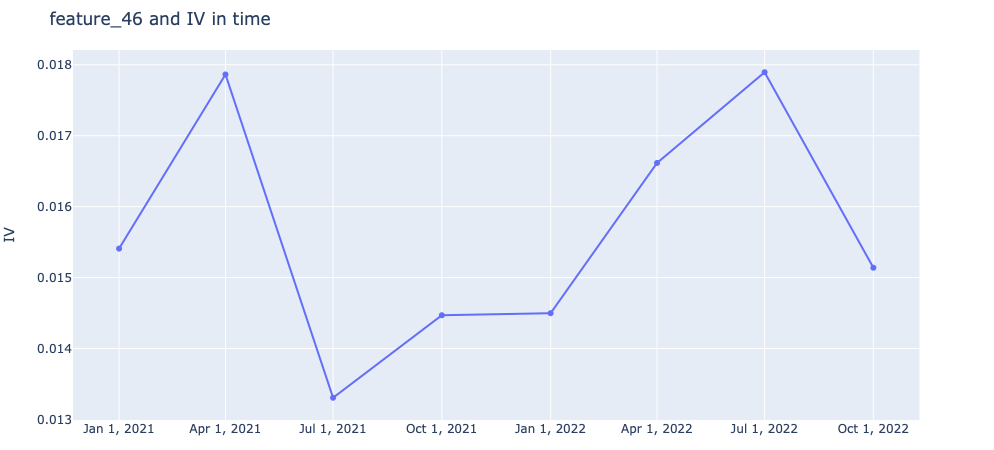

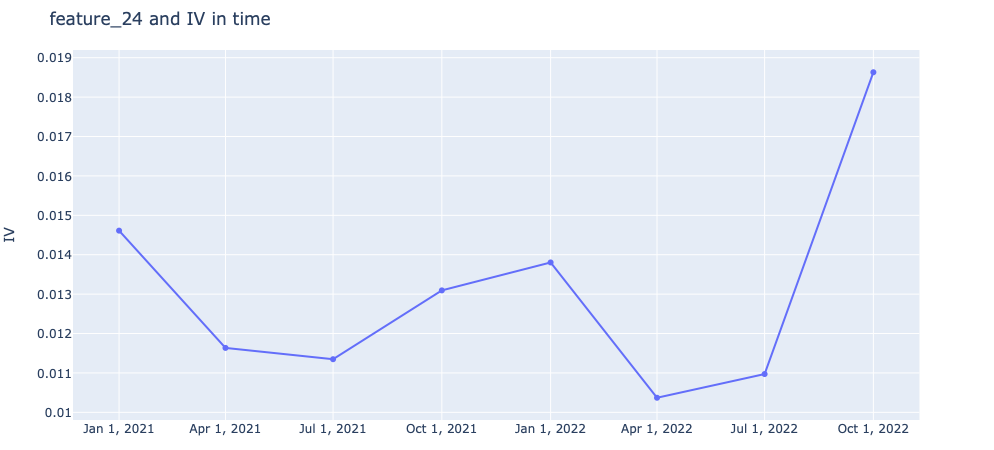

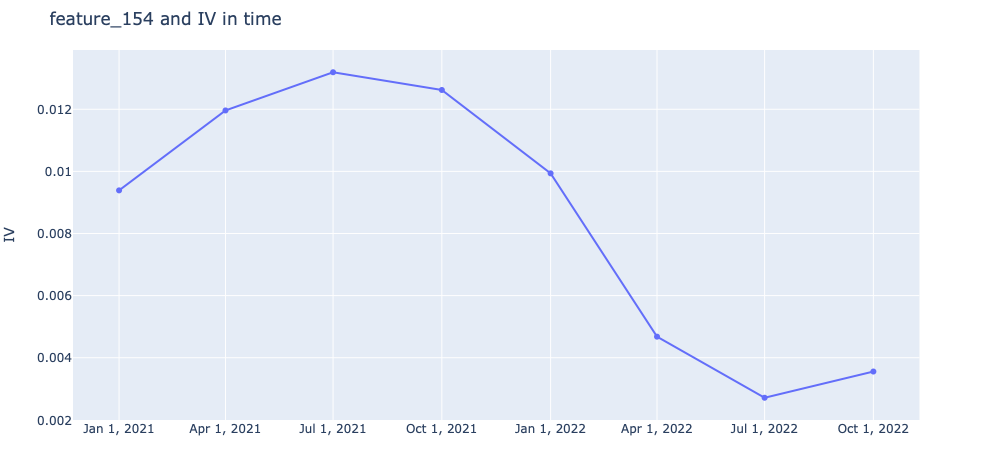

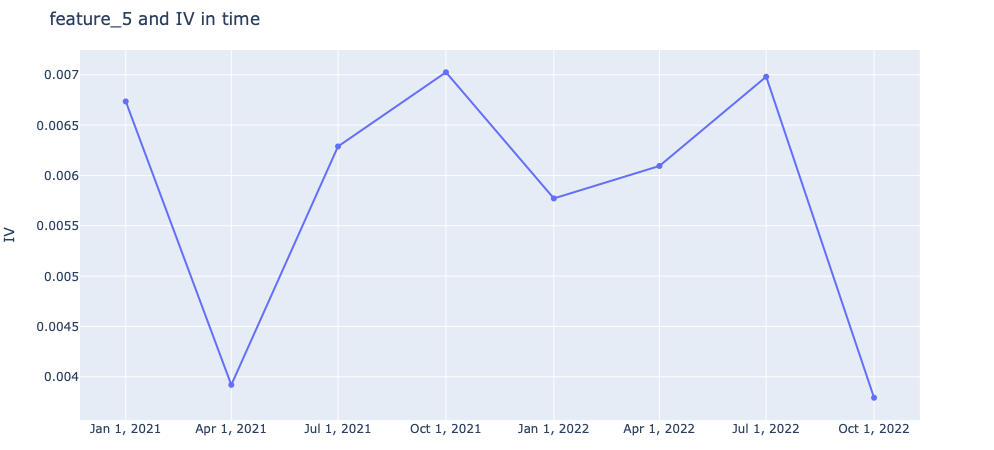

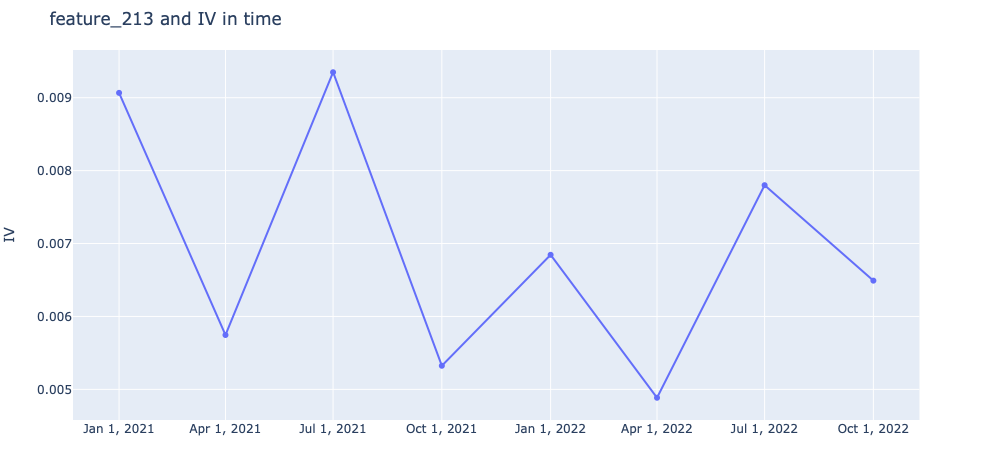

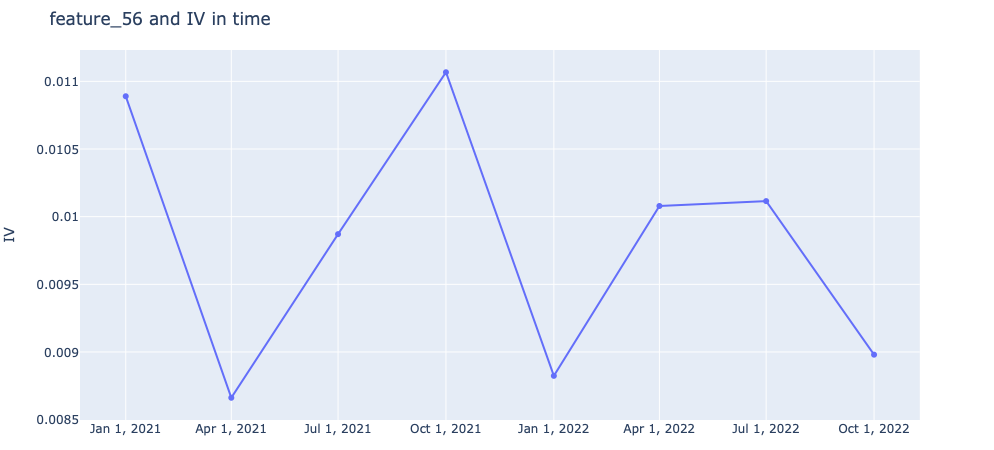

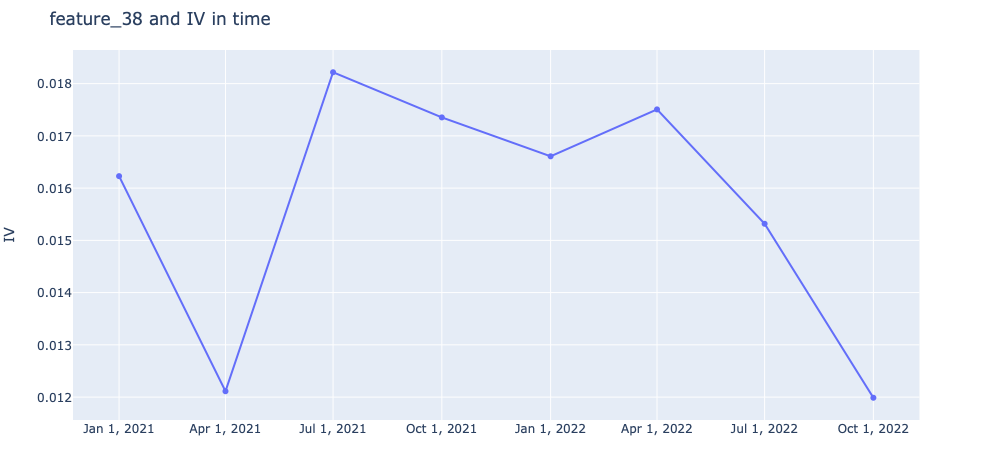

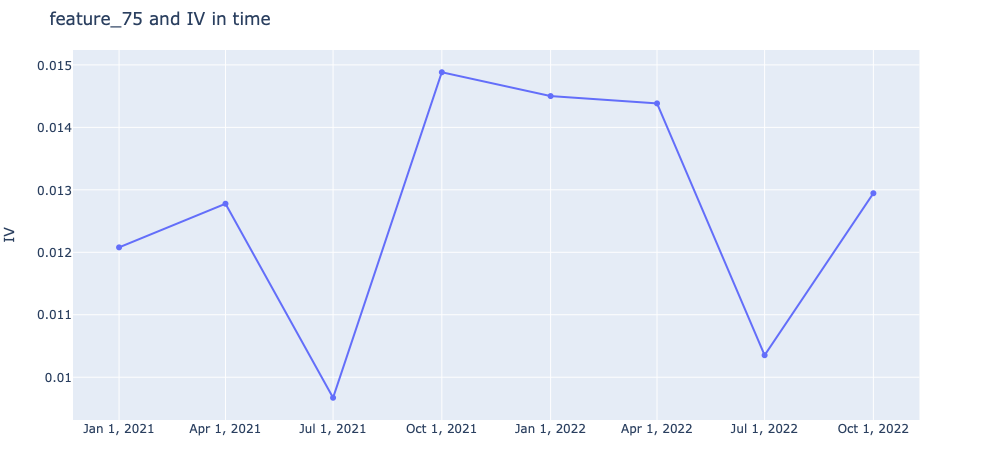

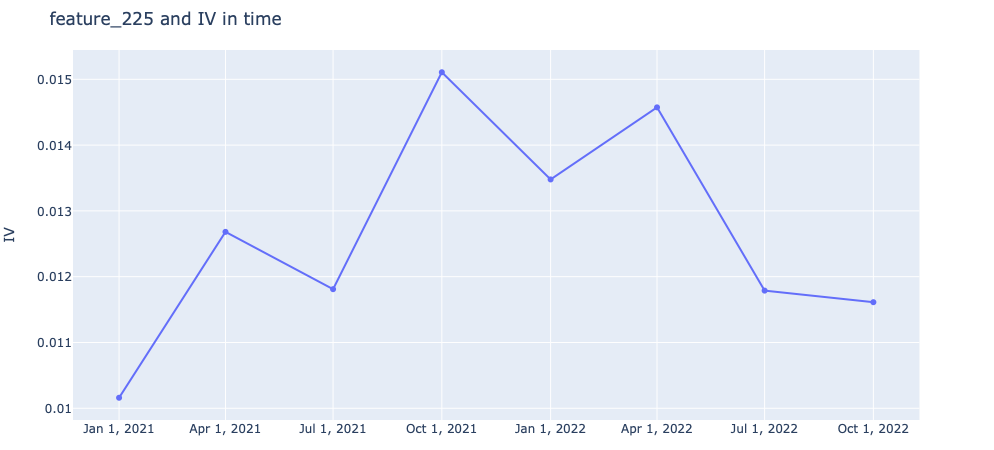

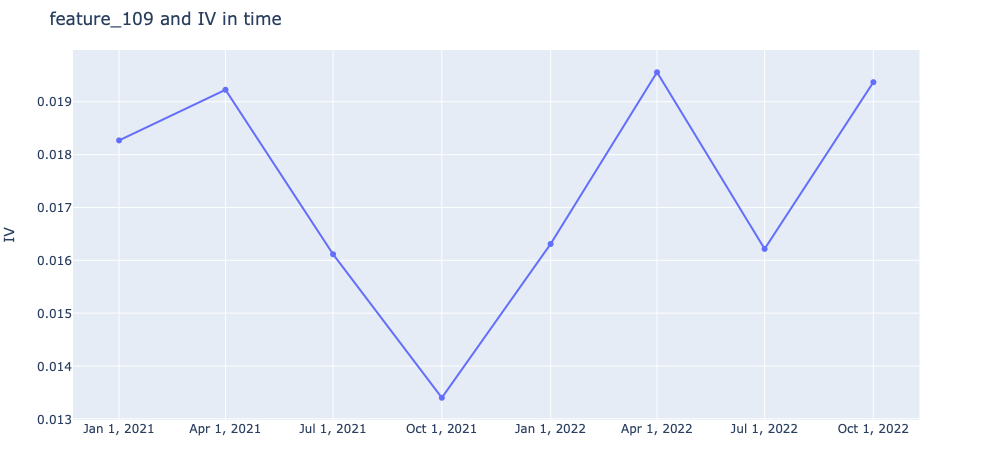

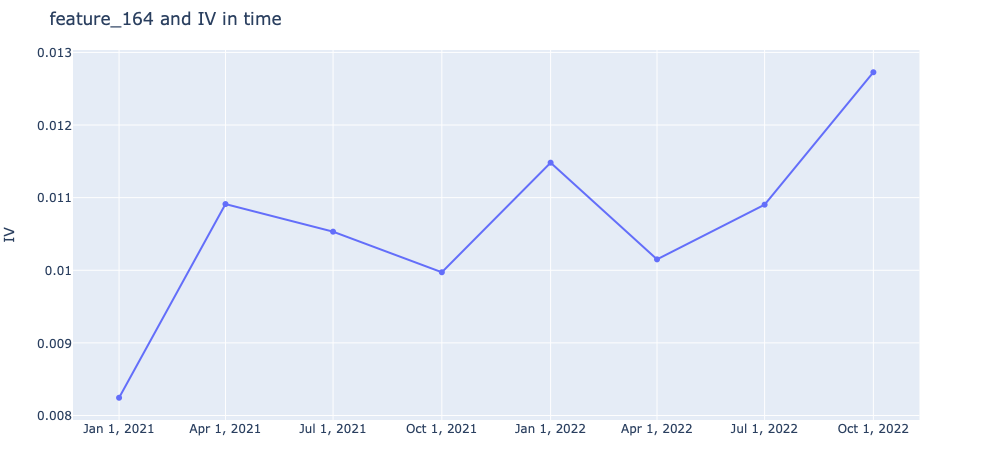

In [29]:
for feature in top_gain_features:
  plot_metric_time(df[feature], df['target'], df['quarter'])

Заметим, что качество фичи 154 заметно деградирует со временем. Остальные фичи достаточно стабильны

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [31]:
top15features_stable = [feature for feature in top_gain_features if feature != 'feature_154']

In [162]:
df_for_logreg = df[top15features_stable + ['date', 'month', 'quarter', 'target', 'sample_part']]

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score(target, values)


    # формула выше
    sum_target_zeros = np.bincount(buckets, weights=(target == 0))
    sum_target_ones = np.bincount(buckets, weights=(target == 1))
    badrate = sum_target_ones / (sum_target_zeros + sum_target_ones)
    badrate[badrate == 0] = 0.001
    badrate[badrate == 1] = 0.999
    offset = logit(np.sum(target)/target.shape[0])
    woe = woe_transform(badrate, offset)


    IV = np.sum((sum_target_ones / np.sum(target) - sum_target_zeros / (target.shape[0] - np.sum(target))) * woe)

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    info = calc_buckets_info(values, target, buckets)
    R_sqr = r2_score(info['woe'], info['line'], sample_weight = np.unique(buckets, return_counts = True)[1])

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [34]:
top_numeric_features = [feature for feature in top15features_stable if feature in numeric_features]
top_numeric_features


['feature_124',
 'feature_30',
 'feature_117',
 'feature_46',
 'feature_24',
 'feature_5',
 'feature_213',
 'feature_56',
 'feature_38',
 'feature_75',
 'feature_225',
 'feature_109',
 'feature_164']

In [35]:
df_for_logreg_train = df_for_logreg[df_for_logreg['sample_part'] == 'train'].reset_index(drop = True)


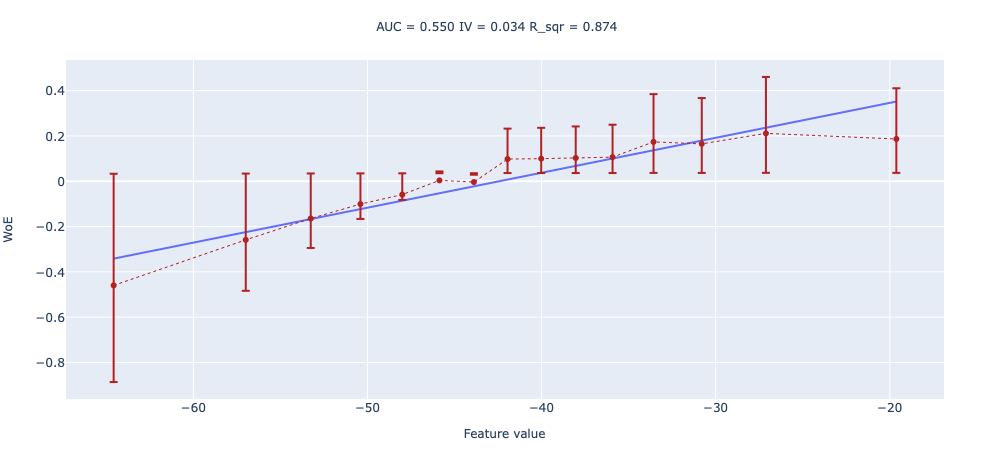

In [36]:
feature = top_numeric_features[0]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

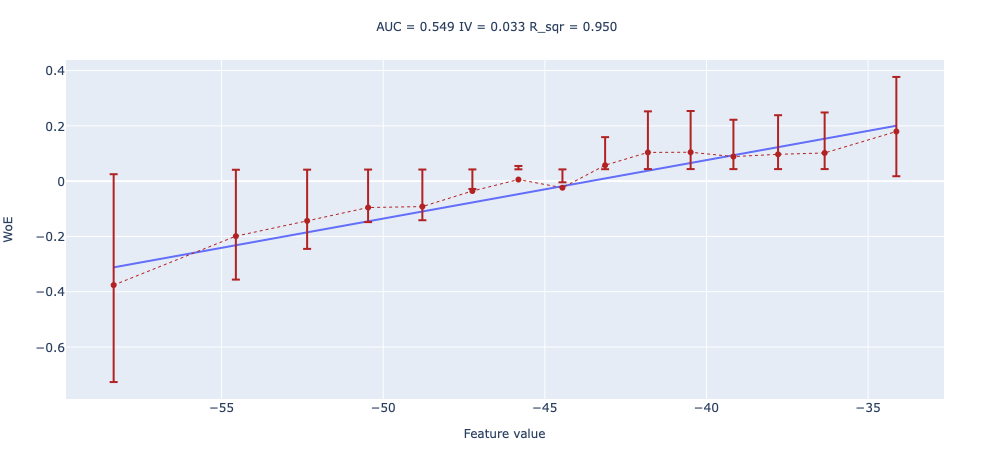

In [37]:
feature = top_numeric_features[0]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), -59, -34), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

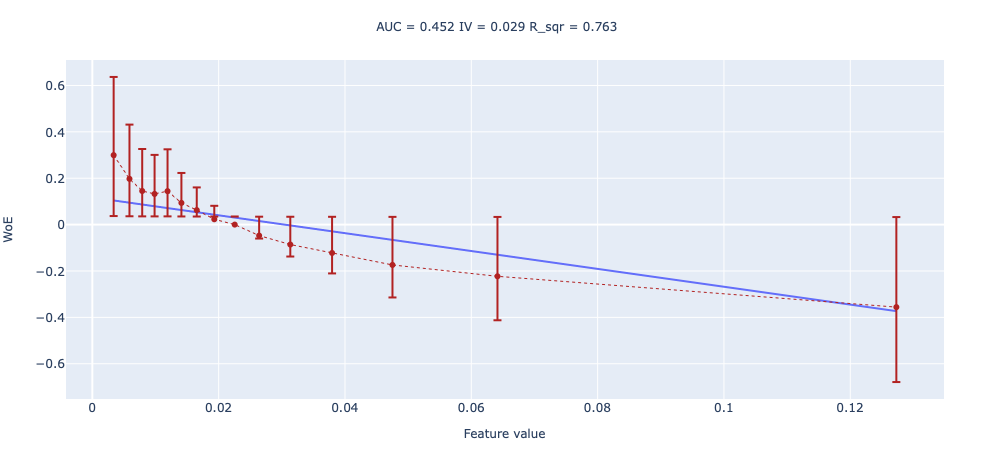

In [39]:
feature = top_numeric_features[1]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

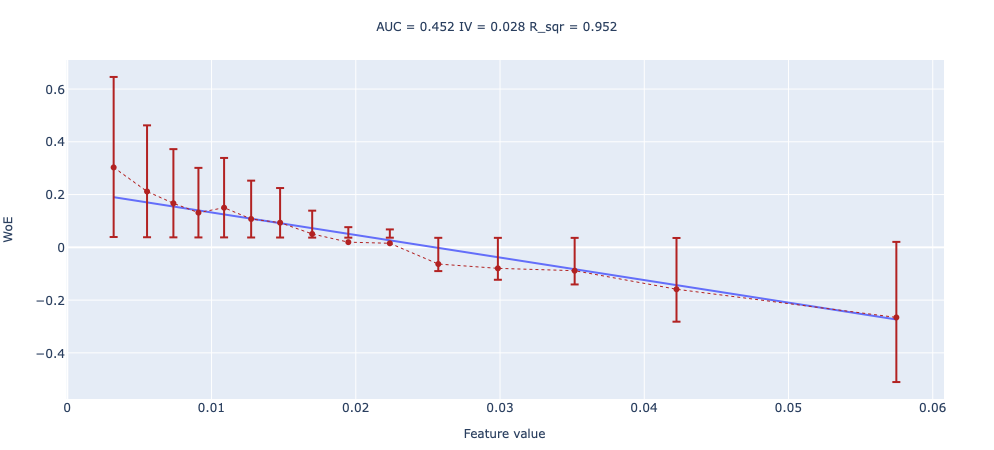

In [40]:
feature = top_numeric_features[1]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), 0, 0.06), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

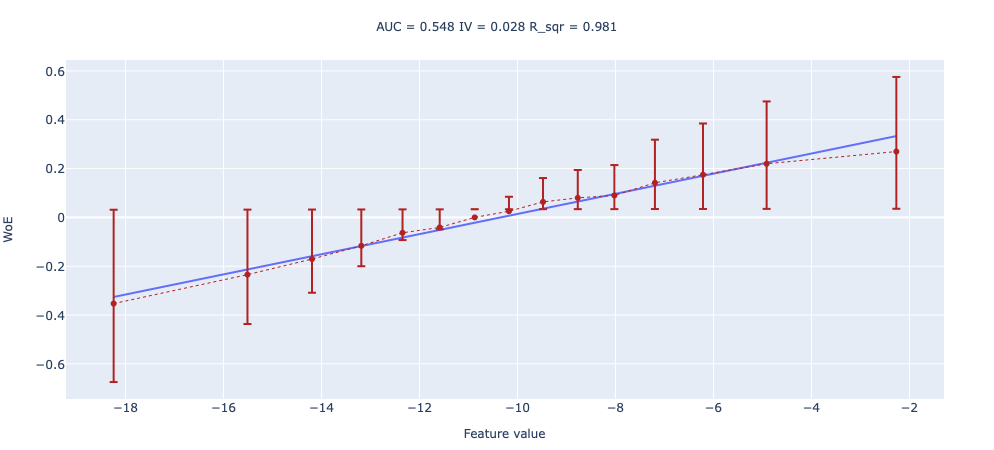

In [41]:
feature = top_numeric_features[2]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

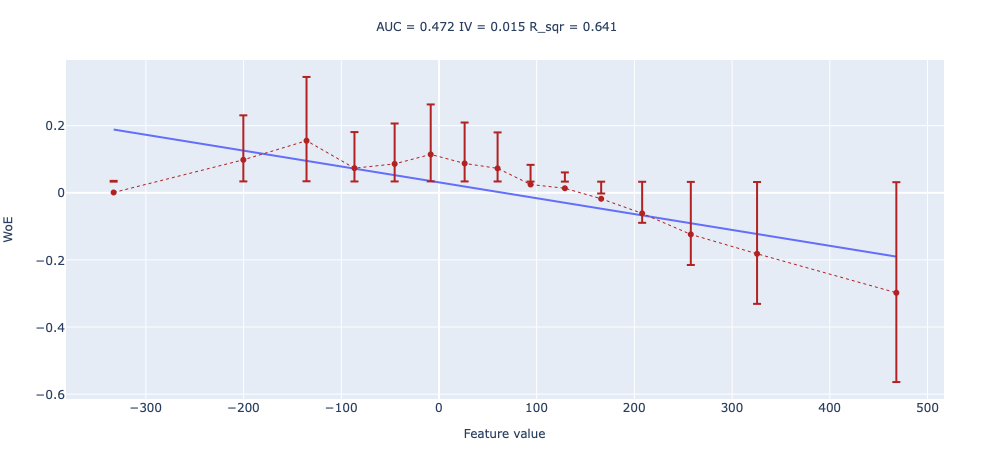

In [42]:
feature = top_numeric_features[3]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

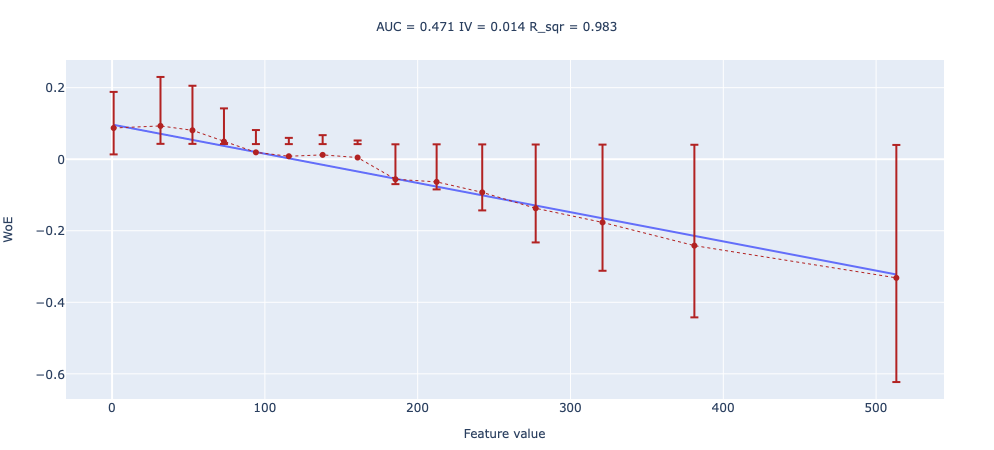

In [43]:
feature = top_numeric_features[3]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), 0, 1000), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

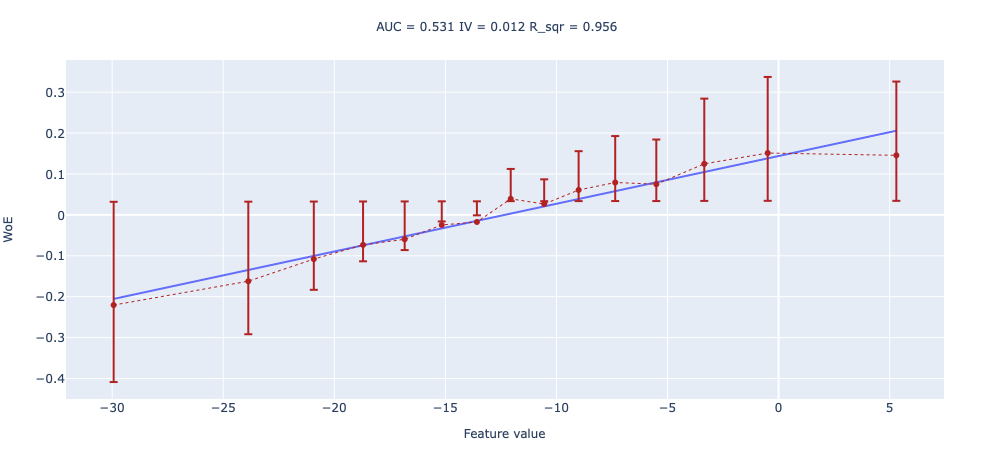

In [44]:
feature = top_numeric_features[4]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

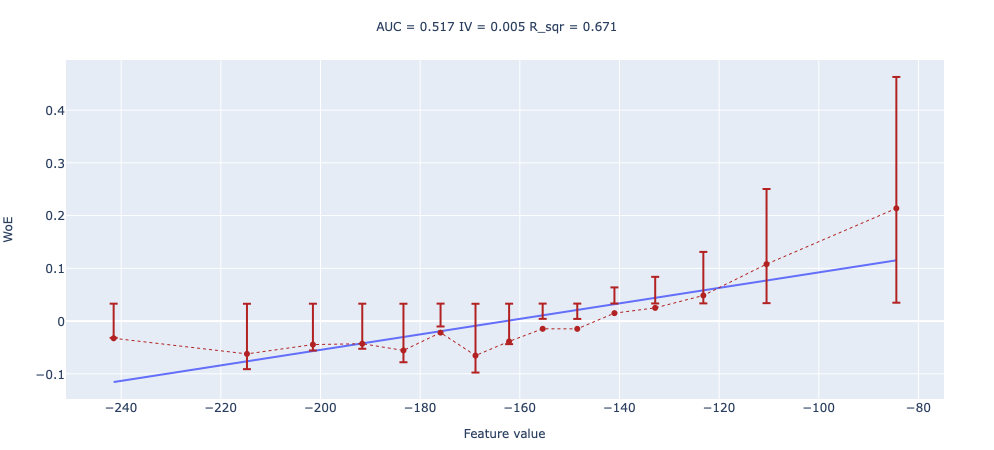

In [45]:
feature = top_numeric_features[5]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

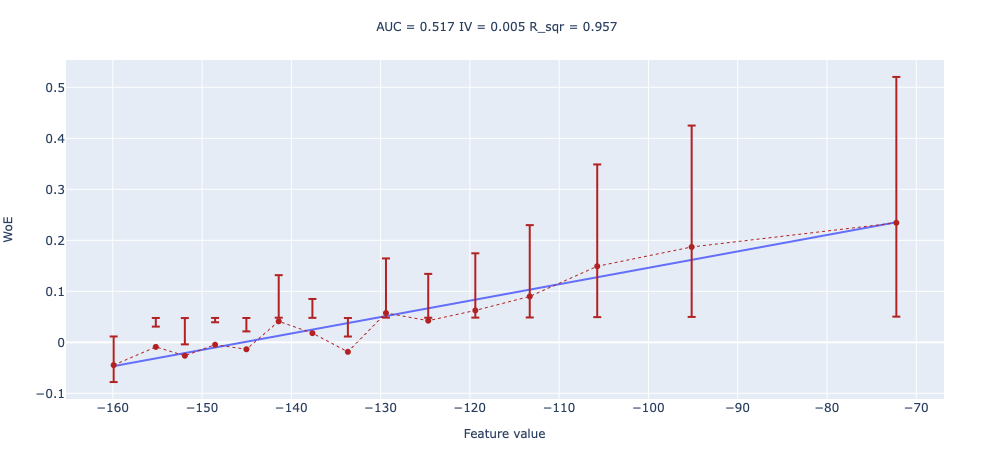

In [46]:
feature = top_numeric_features[5]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), -160, 0), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

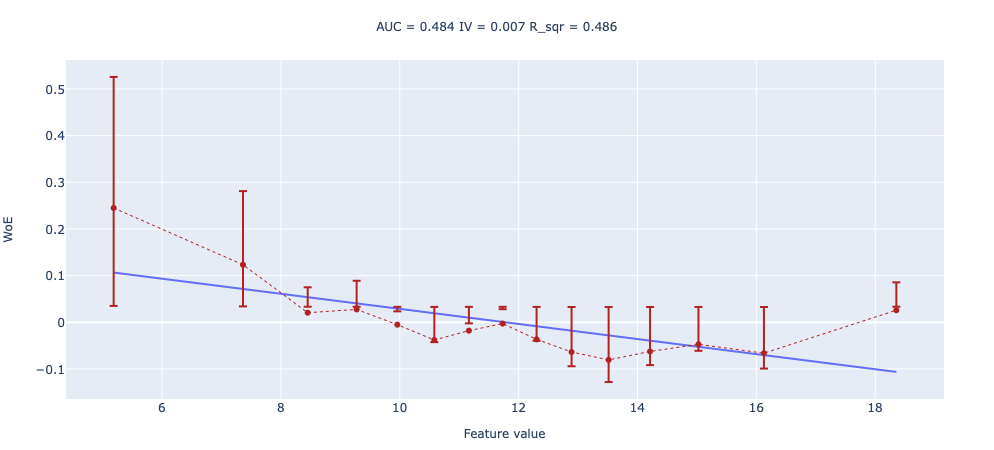

In [47]:
feature = top_numeric_features[6]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

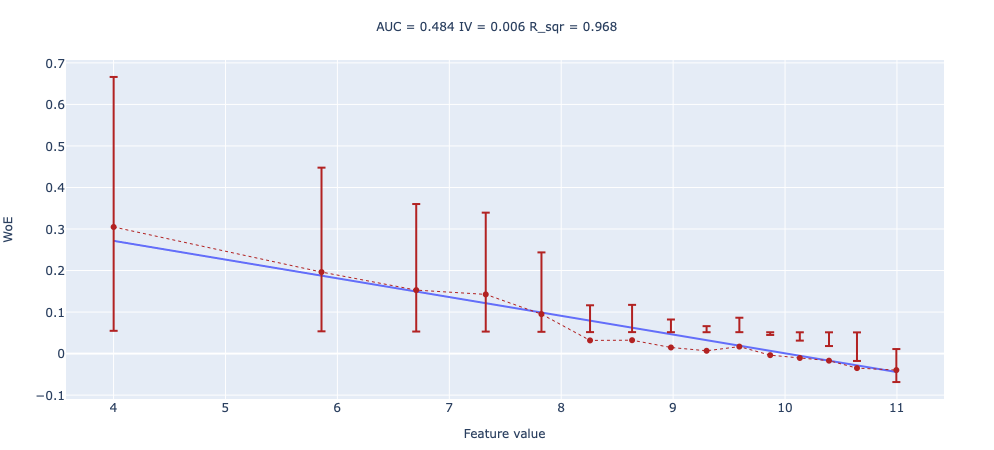

In [48]:
feature = top_numeric_features[6]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), 0, 11), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

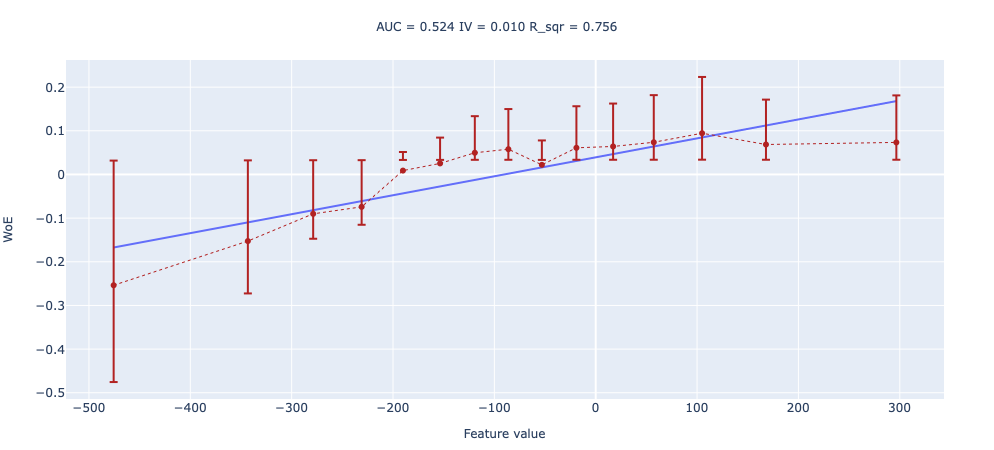

In [49]:
feature = top_numeric_features[7]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

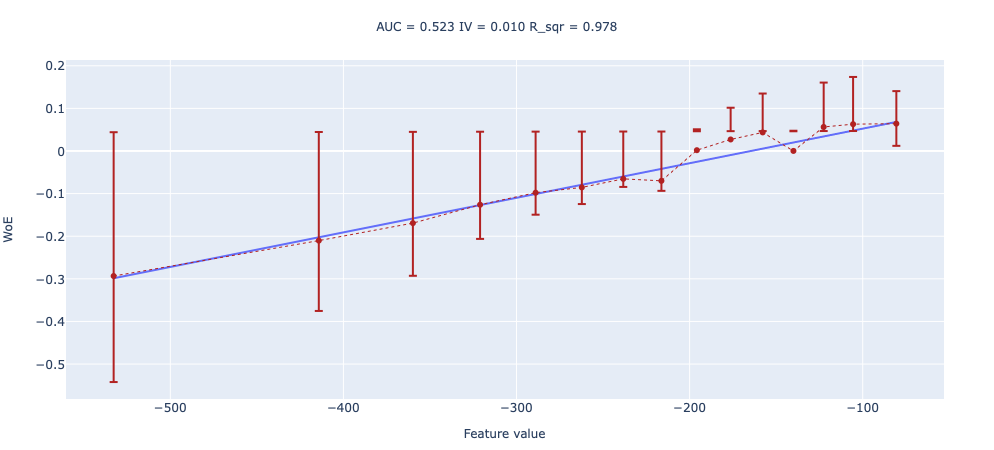

In [50]:
feature = top_numeric_features[7]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), -1000, -80), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

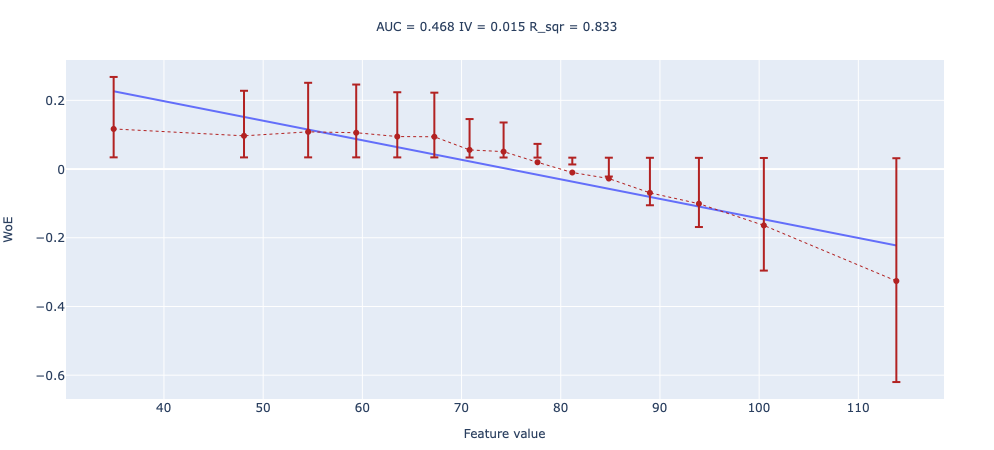

In [51]:
feature = top_numeric_features[8]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

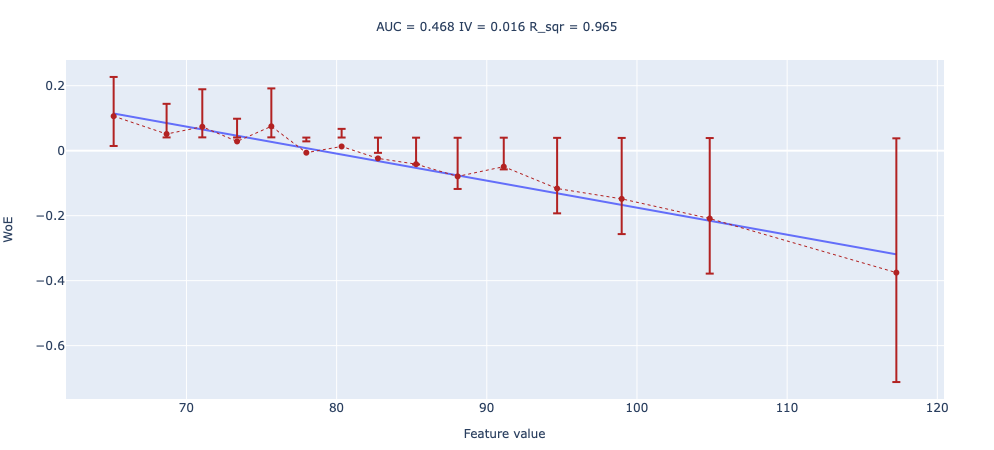

In [52]:
feature = top_numeric_features[8]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), 65, 200), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

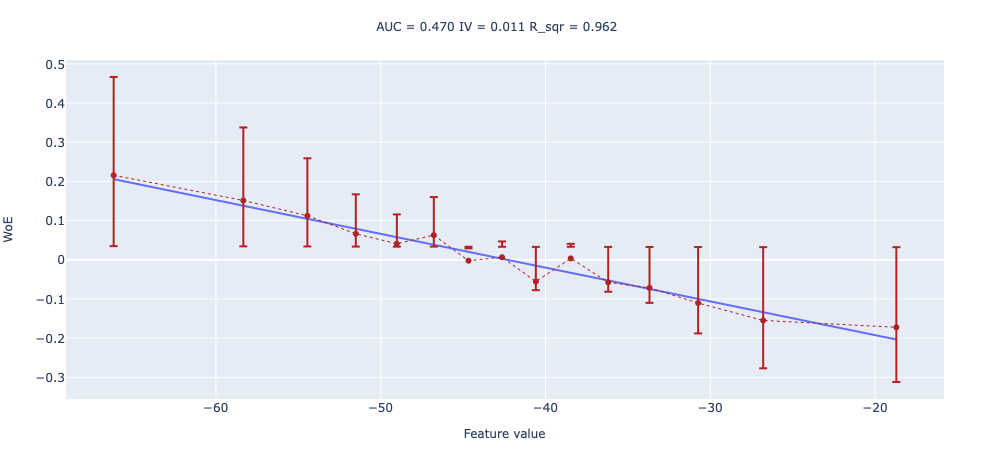

In [53]:
feature = top_numeric_features[9]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

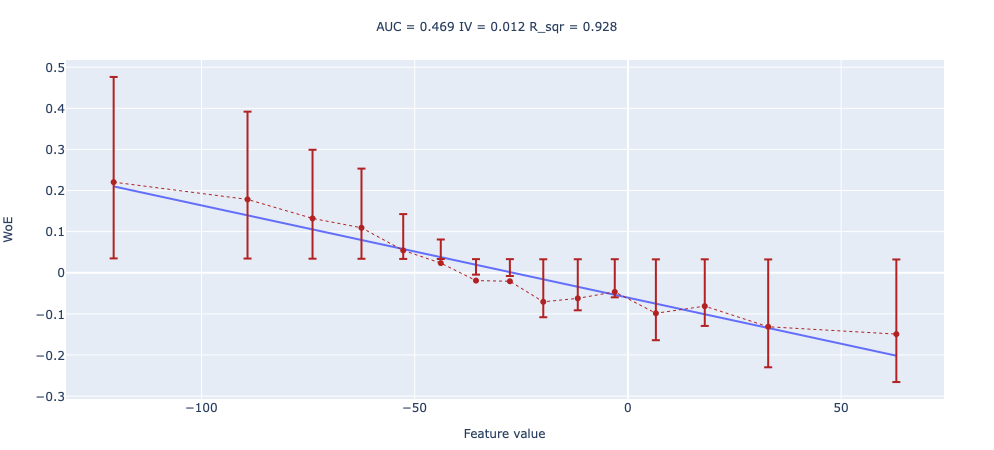

In [54]:
feature = top_numeric_features[10]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

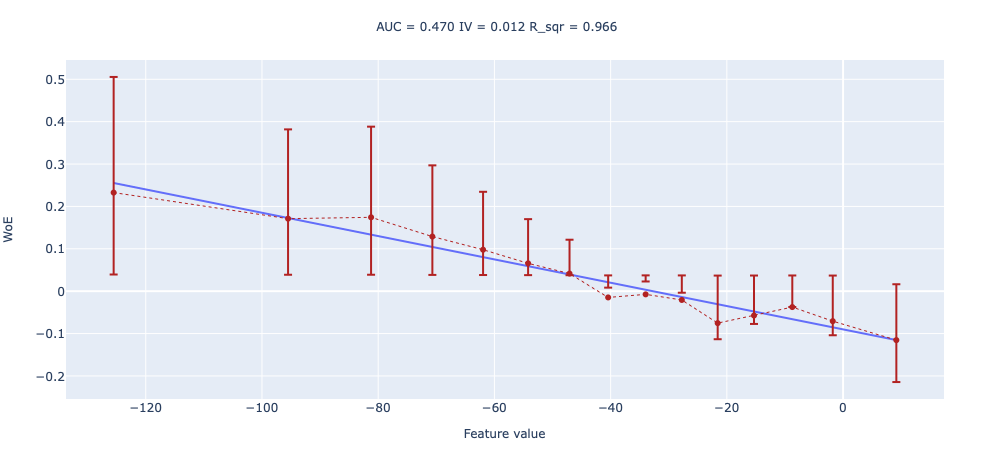

In [55]:
feature = top_numeric_features[10]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), -1000, 10), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

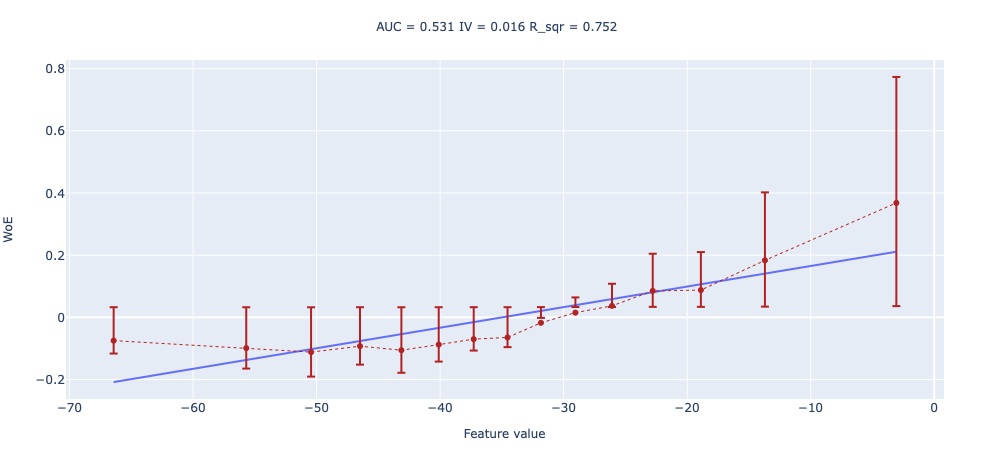

In [56]:
feature = top_numeric_features[11]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

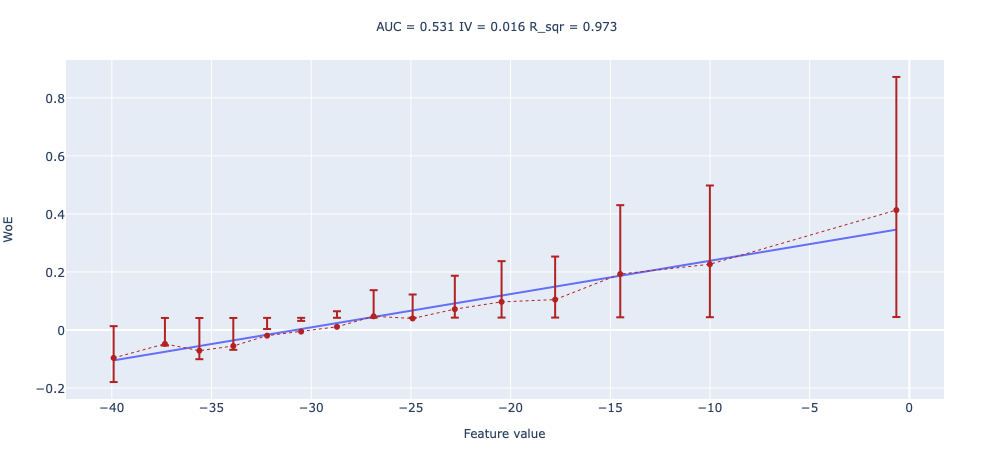

In [57]:
feature = top_numeric_features[11]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), -40, 10), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

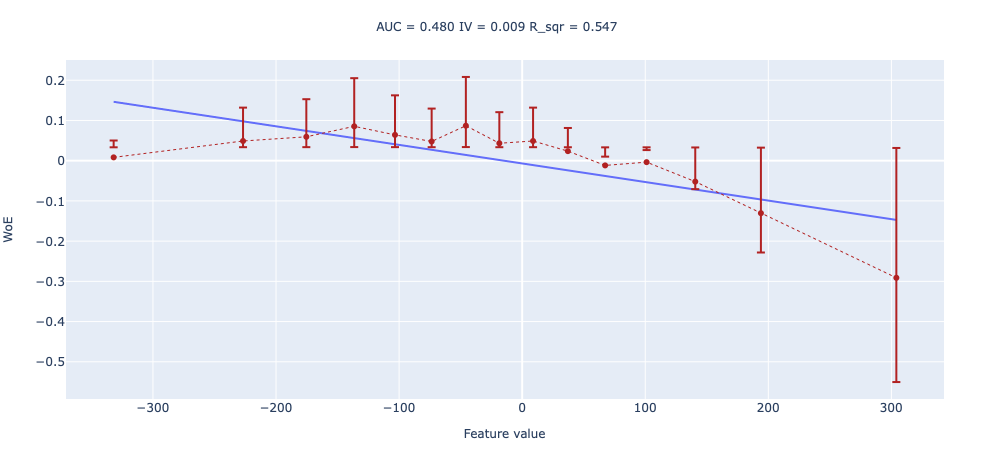

In [58]:
feature = top_numeric_features[12]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(df_for_logreg_train[feature].dropna().to_numpy(), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

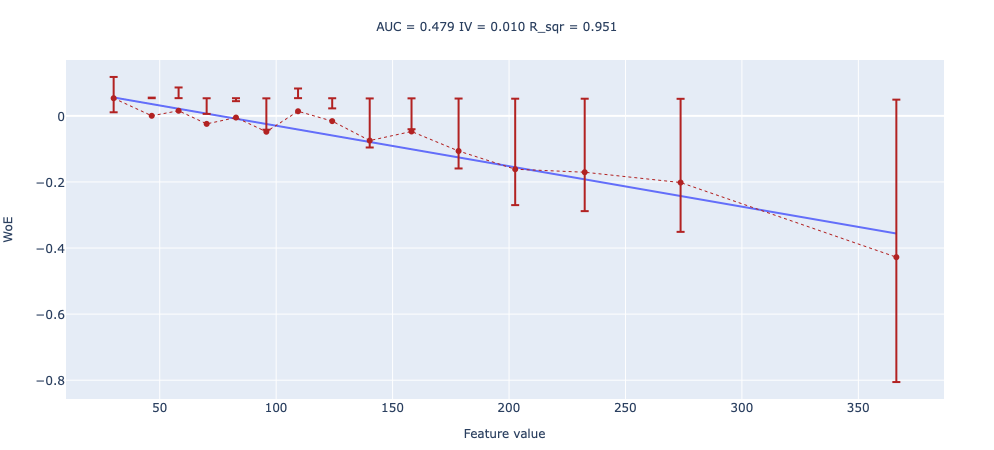

In [59]:
feature = top_numeric_features[12]
missing = np.where(df_for_logreg_train[feature].isna())[0]
woe_line(np.clip(df_for_logreg_train[feature].dropna().to_numpy(), 30, 500), df_for_logreg_train['target'].drop(missing).to_numpy(), 15)

In [163]:
non_na_indices = df_for_logreg['feature_124'].notna()
df_for_logreg.loc[non_na_indices, 'feature_124'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_124'].to_numpy(), -59, -34)
non_na_indices = df_for_logreg['feature_30'].notna()
df_for_logreg.loc[non_na_indices, 'feature_30'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_30'].to_numpy(), 0, 0.06)
non_na_indices = df_for_logreg['feature_46'].notna()
df_for_logreg.loc[non_na_indices, 'feature_46'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_46'].to_numpy(), 0, 1000)
non_na_indices = df_for_logreg['feature_5'].notna()
df_for_logreg.loc[non_na_indices, 'feature_5'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_5'].to_numpy(), -160, -0)
non_na_indices = df_for_logreg['feature_213'].notna()
df_for_logreg.loc[non_na_indices, 'feature_213'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_213'].to_numpy(), 0, 11)
non_na_indices = df_for_logreg['feature_56'].notna()
df_for_logreg.loc[non_na_indices, 'feature_56'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_56'].to_numpy(), -1000, -80)
non_na_indices = df_for_logreg['feature_38'].notna()
df_for_logreg.loc[non_na_indices, 'feature_38'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_38'].to_numpy(), 65, 200)
non_na_indices = df_for_logreg['feature_225'].notna()
df_for_logreg.loc[non_na_indices, 'feature_225'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_225'].to_numpy(), -1000, -10)
non_na_indices = df_for_logreg['feature_109'].notna()
df_for_logreg.loc[non_na_indices, 'feature_109'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_109'].to_numpy(), -40, 10)
non_na_indices = df_for_logreg['feature_164'].notna()
df_for_logreg.loc[non_na_indices, 'feature_164'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_164'].to_numpy(), 30, 500)


Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

Заполнение средним может 
1) сильно исказить распределение, особенно, если оно имеет жирные хвосты
2) увеличить шум, если есть огромные аутлайеры
3) можем потерять зависимость фичи от (например) времени

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [62]:
df_for_logreg.isna().sum()

feature_124    58984
feature_30     34475
feature_117        0
feature_140    36943
feature_46         0
feature_24         0
feature_5          0
feature_213        0
feature_56         0
feature_38         0
feature_75         0
feature_225        0
feature_109        0
feature_164        0
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

In [165]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
train_data = df_for_logreg[df_for_logreg['sample_part'].isin(['train', 'val'])]
test_data = df_for_logreg[df_for_logreg['sample_part'] == 'test']
imputer_feature_124 = SimpleImputer(strategy='mean')
train_data['feature_124'] = imputer_feature_124.fit_transform(train_data[['feature_124']])
test_data['feature_124'] = imputer_feature_124.transform(test_data[['feature_124']])
imputer_feature_30 = SimpleImputer(strategy='mean')
train_data['feature_30'] = imputer_feature_30.fit_transform(train_data[['feature_30']])
test_data['feature_30'] = imputer_feature_30.transform(test_data[['feature_30']])
encoder_feature_140 = OneHotEncoder()
encoded_feature_140 = encoder_feature_140.fit_transform(df_for_logreg[['feature_140']])
df_for_logreg_final = df_for_logreg
df_for_logreg_final.loc[train_data.index, ['feature_124', 'feature_30']] = train_data[['feature_124', 'feature_30']]
df_for_logreg_final.loc[test_data.index, ['feature_124', 'feature_30']] = test_data[['feature_124', 'feature_30']]
df_for_logreg_final = pd.concat([df_for_logreg, pd.DataFrame(encoded_feature_140.toarray(), columns=encoder_feature_140.get_feature_names_out(['feature_140']))], axis=1)
df_for_logreg_final = df_for_logreg_final.drop(columns = ['feature_140'])



/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/1301834280.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/1301834280.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/1301834280.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Можно проверить адекватность такого заполнения проверкой на линейность

In [216]:
df_for_logreg_train = df_for_logreg[df_for_logreg['sample_part'] == 'train'].reset_index(drop = True)


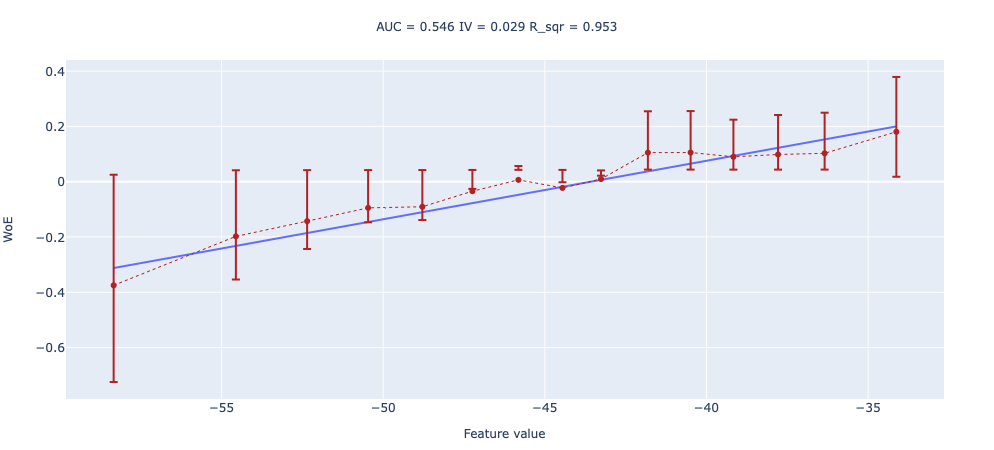

In [217]:
woe_line(df_for_logreg_train['feature_124'].to_numpy(), df_for_logreg_train['target'].to_numpy(), 15)

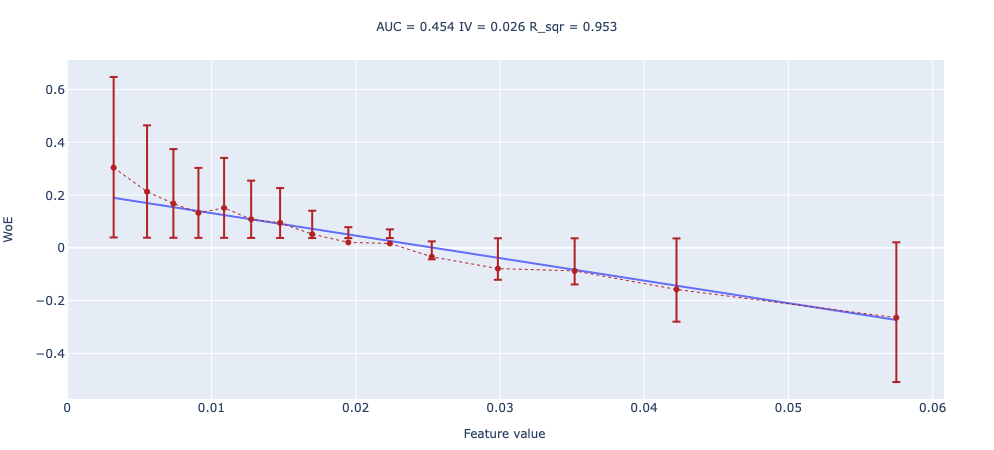

In [218]:
woe_line(df_for_logreg_train['feature_30'].to_numpy(), df_for_logreg_train['target'].to_numpy(), 15)

С линейностью все в порядке, мы молодцы

In [166]:
df_for_logreg_final = df_for_logreg_final.drop(columns = ['feature_140_0.0']) #дропаем одну из колонок ванхота, чтобы избежать проблем
df_for_logreg_final.columns

Index(['feature_124', 'feature_30', 'feature_117', 'feature_46', 'feature_24',
       'feature_5', 'feature_213', 'feature_56', 'feature_38', 'feature_75',
       'feature_225', 'feature_109', 'feature_164', 'date', 'month', 'quarter',
       'target', 'sample_part', 'feature_140_1.0', 'feature_140_2.0',
       'feature_140_3.0', 'feature_140_4.0', 'feature_140_5.0',
       'feature_140_6.0', 'feature_140_7.0', 'feature_140_8.0',
       'feature_140_9.0', 'feature_140_10.0', 'feature_140_11.0',
       'feature_140_12.0', 'feature_140_13.0', 'feature_140_14.0',
       'feature_140_15.0', 'feature_140_16.0', 'feature_140_17.0',
       'feature_140_18.0', 'feature_140_19.0', 'feature_140_20.0',
       'feature_140_21.0', 'feature_140_22.0', 'feature_140_23.0',
       'feature_140_24.0', 'feature_140_25.0', 'feature_140_26.0',
       'feature_140_27.0', 'feature_140_28.0', 'feature_140_29.0',
       'feature_140_30.0', 'feature_140_31.0', 'feature_140_32.0',
       'feature_140_33.0', 'fea

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [66]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [67]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [221]:
def stepwise_1(
        df: pd.DataFrame,
        features: list[str],
        target: str,
        alpha_in: float = 0.01,
        alpha_out:  float = 0.05
        ) -> list[str]:

    selected_features = list()

    while True:

        # forward step
        best_feature = None
        feature_to_add = False
        
        if (len(selected_features) < len(features)):

            best_p_value = float('inf')
            for feature in features:
                if feature not in selected_features:
                    if len(selected_features) > 0:
                        X = df[selected_features.copy()]
                        X_scaled = StandardScaler().fit_transform(X)
                        model = LogisticRegression()
                        model.fit(X_scaled, df[target])
                        ll_short = log_loss(df[target], model.predict_proba(X_scaled), normalize=False)
                        selected_columns = selected_features + [feature]
                        X_long = df.loc[:, selected_columns].copy()
                        X_long_scaled = StandardScaler().fit_transform(X_long)
                        model_long = LogisticRegression()
                        model_long.fit(X_long_scaled, df[target])
                        ll_long = log_loss(df[target], model_long.predict_proba(X_long_scaled), normalize=False)
                        p_value = likelihood_ratio_test(ll_short, ll_long)
                    else:
                        const = [(df[(df[target] == 1)].count()/df.count())[0]] * len(df[target])
                        ll_short = log_loss(df[target], const, normalize=False)
                        selected_columns = selected_features + [feature]
                        X_long = df.loc[:, selected_columns].copy()
                        X_long_scaled = StandardScaler().fit_transform(X_long)
                        model_long = LogisticRegression()
                        model_long.fit(X_long_scaled, df[target])
                        ll_long = log_loss(df[target], model_long.predict_proba(X_long_scaled), normalize=False)
                        p_value = likelihood_ratio_test(ll_short, ll_long)
                    if p_value < best_p_value:
                        best_p_value = p_value
                        best_feature = feature

            if best_p_value < alpha_in:
                feature_to_add = True
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная '{best_feature}', p-value: {best_p_value}")

        # backward step
        worst_feature = None
        feature_to_drop = False
        if (len(selected_features) > 1):

            worst_p_value = -float('inf')
            for feature in selected_features:
                X = df[selected_features.copy()]
                X_scaled = StandardScaler().fit_transform(X)
                model = LogisticRegression()
                model.fit(X_scaled, df[target])
                ll_full = log_loss(df[target], model.predict_proba(X_scaled), normalize=False)
                X_reduced = df[selected_features.copy()]
                X_reduced.drop(columns=feature, inplace=True)
                X_reduced_scaled = StandardScaler().fit_transform(X_reduced)
                model_reduced = LogisticRegression()
                model_reduced.fit(X_reduced_scaled, df[target])
                ll_reduced = log_loss(df[target], model_reduced.predict_proba(X_reduced_scaled), normalize=False)
                p_value = likelihood_ratio_test(ll_reduced, ll_full)
                if p_value > worst_p_value:
                    worst_p_value = p_value
                    worst_feature = feature

            if worst_p_value > alpha_out:
                feature_to_drop = True
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная '{worst_feature}', p-value: {worst_p_value}")

        if not (feature_to_add or feature_to_drop):
            break

    return selected_features

In [69]:
train_data = df_for_logreg_final[df_for_logreg_final['sample_part'].isin(['train', 'val'])]
final_features = [feature for feature in df_for_logreg_final.columns if feature not in ['date', 'month', 'quarter', 'target', 'sample_part']]

In [70]:
selected_features = stepwise_1(train_data, final_features, 'target', alpha_in = 0.01, alpha_out = 0.02)

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/

В модель была добавлена переменная 'feature_124', p-value: 0.0
В модель была добавлена переменная 'feature_30', p-value: 0.0


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



В модель была добавлена переменная 'feature_117', p-value: 0.0


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



В модель была добавлена переменная 'feature_164', p-value: 8.713529267302552e-237


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_109', p-value: 1.2955610462993754e-198


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_38', p-value: 1.0504684986495204e-205


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_24', p-value: 3.4655363289254766e-162


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_225', p-value: 2.787910358300355e-151


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_213', p-value: 3.310919038948757e-152


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_5', p-value: 3.928844887074321e-116


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_46', p-value: 3.5029377868538976e-83


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_56', p-value: 2.9750971197956025e-72


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

В модель была добавлена переменная 'feature_75', p-value: 1.79895781636656e-46


/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3930836644.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipy

In [167]:
selected_features

['feature_124',
 'feature_30',
 'feature_117',
 'feature_164',
 'feature_109',
 'feature_38',
 'feature_24',
 'feature_225',
 'feature_213',
 'feature_5',
 'feature_46',
 'feature_56',
 'feature_75']

In [168]:
last_df = df_for_logreg_final[selected_features]

In [84]:
last_df

feature_124  feature_30  feature_117  feature_164  feature_109  \
22620    -59.000000    0.036732   -17.226707    83.424262   -20.603835   
478621   -34.000000    0.059557    -8.564242    30.000000   -25.523515   
372254   -43.307479    0.060000   -10.249472   111.868069   -30.064426   
2596     -42.117574    0.021008   -13.114987    30.000000   -37.356662   
216892   -48.599477    0.060000    -7.378194    30.000000   -38.641177   
...             ...         ...          ...          ...          ...   
196513   -34.698016    0.024842   -13.148536   114.011177   -27.467429   
108604   -57.378146    0.010241   -18.802413    30.000000   -40.000000   
141359   -46.912357    0.013355   -11.941628    30.000000   -39.999779   
443018   -34.000000    0.043060   -12.865323   169.616312    -9.474269   
310653   -43.307479    0.024906   -11.315535    30.000000   -40.000000   

        feature_38  feature_24  feature_225  feature_213   feature_5  \
22620    81.613713   -7.179830   -10.000000     7.458468 -160.000000   
478621   65.000000  -23.797875  -107.082378    10.884534 -160.000000   
372254   65.000000  -22.976857   -10.000000    11.000000 -154.503339   
2596     65.000000  -14.087877   -10.000000    11.000000 -131.553444   
216892  104.813062  -17.195954   -55.494545     8.274292 -160.000000   
...            ...         ...          ...          ...         ...   
196513  102.181440   -1.997241   -16.127165     8.779791 -160.000000   
108604  115.324044  -11.417951  -124.008226    11.000000  -90.369206   
141359  112.985724  -32.527420  -121.988519    11.000000 -155.056899   
443018  105.113244   -3.723810   -85.791771    10.443730 -139.585458   
310653  131.833319  -18.952444   -29.940244    11.000000 -135.013833   

        feature_46  feature_56  feature_75  
22620   115.319640 -258.724816  -37.566036  
478621  172.981221  -80.000000  -51.686117  
372254    0.000000 -270.127459  -32.603922  
2596     85.009499 -463.492274  -45.032987  
216892   43.108790  -80.000000  -58.049155  
...            ...         ...         ...  
196513  266.894924  -80.000000  -38.487619  
108604   30.165443 -152.054084  -58.078548  
141359    0.000000  -80.000000  -35.814129  
443018    0.000000  -80.000000  -27.440006  
310653    0.000000  -93.182733  -58.961194  

[500000 rows x 13 columns]

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [74]:
X = last_df
y = df_for_logreg_final['target']
train_and_val_indices = df_for_logreg_final['sample_part'].isin(['train', 'val'])
X_train = X[train_and_val_indices]
y_train = y[train_and_val_indices]
X_test = X[df_for_logreg_final['sample_part'] == 'test']
y_test = y[df_for_logreg_final['sample_part'] == 'test']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_train_pred_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC on train set:", roc_auc_train)
print("ROC AUC on test set:", roc_auc_test)

ROC AUC on train set: 0.6154564463517418
ROC AUC on test set: 0.6147295152176809


Получаем небольшую печальку. Аук на тесте пока меньше 0.622. Степвайз полностью выкинул переменную 140, но есть идея. Что, если на ней все же адекватно отношение порядка? Попробуем отнестись к ней как к числовой. Посмотрим на ее поведение во времени и линеаризуем ее.

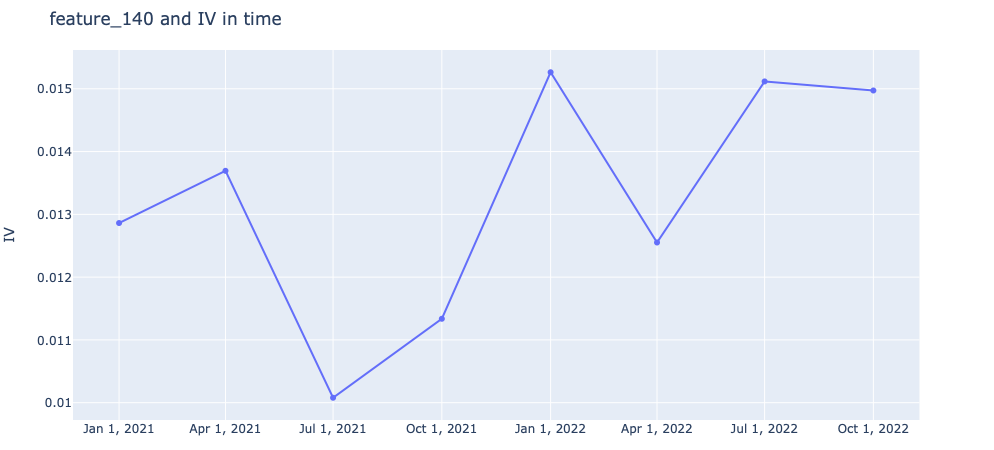

In [169]:
plot_metric_time(df['feature_140'], df['target'], df['quarter'])

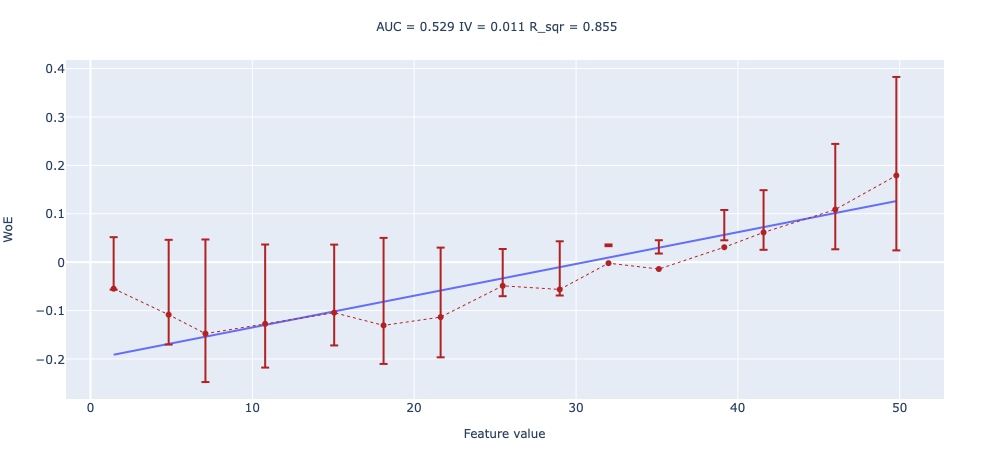

In [170]:
feature = 'feature_140'
df_train = df[df['sample_part'].isin(['train'])].reset_index()
missing = np.where(df_train[feature].isna())[0]
woe_line(df_train[feature].dropna().to_numpy(), df_train['target'].drop(missing).to_numpy(), min(15, df_train[feature].nunique()))

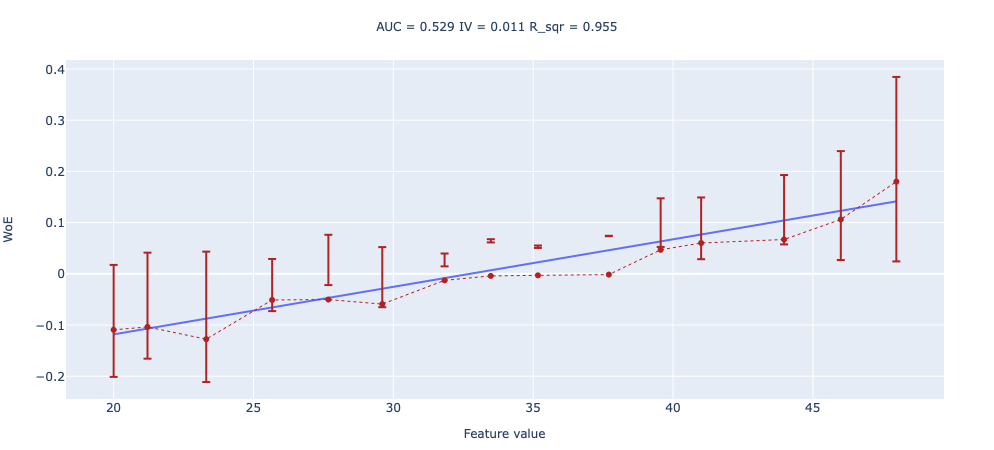

In [171]:
feature = 'feature_140'
df_train = df[df['sample_part'].isin(['train'])].reset_index()
missing = np.where(df_train[feature].isna())[0]
woe_line(np.clip(df_train[feature].dropna().to_numpy(), 20, 48), df_train['target'].drop(missing).to_numpy(), min(15, df_train[feature].nunique()))

In [172]:
last_df = pd.concat([last_df, df[['feature_140']]], axis=1)
non_na_indices = last_df['feature_140'].notna()
last_df.loc[non_na_indices, 'feature_140'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_140'].to_numpy(), 20, 48)

train_data = last_df[train_and_val_indices]
test_data = last_df[df_for_logreg_final['sample_part'] == 'test']
imputer_feature_140 = SimpleImputer(strategy='mean')
train_data['feature_140'] = imputer_feature_140.fit_transform(train_data[['feature_140']])
test_data['feature_140'] = imputer_feature_140.transform(test_data[['feature_140']])
last_df.loc[train_data.index, ['feature_140']] = train_data[['feature_140']]
last_df.loc[test_data.index, ['feature_140']] = test_data[['feature_140']]

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/11607140.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/11607140.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
X = last_df
y = df_for_logreg_final['target']
train_and_val_indices = df_for_logreg_final['sample_part'].isin(['train', 'val'])
X_train = X[train_and_val_indices]
y_train = y[train_and_val_indices]
X_test = X[df_for_logreg_final['sample_part'] == 'test']
y_test = y[df_for_logreg_final['sample_part'] == 'test']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_train_pred_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC on train set:", roc_auc_train)
print("ROC AUC on test set:", roc_auc_test)

ROC AUC on train set: 0.6190133609737847
ROC AUC on test set: 0.6185130965531149


Аук стал повыше, но пока все еще не дотягивает до нужного нам порога. Попробуем подобавлять еще фичи из топа импортанса бустинга

In [174]:
top_gain_ = importance_df.sort_values(by='Gain Importance', ascending=False)[:16]
top_gain_features_ = top_gain_['Feature'].to_list()[-1]

In [175]:
top_gain_features_

'feature_26'

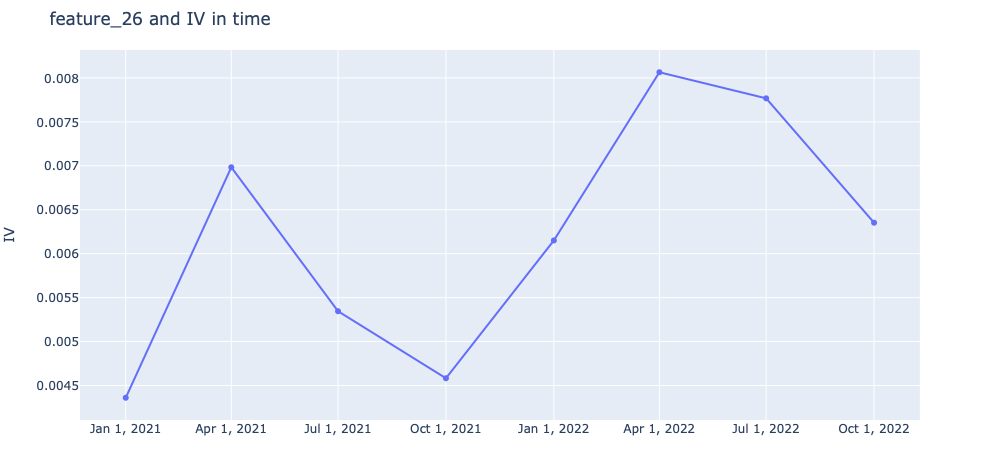

In [176]:
plot_metric_time(df['feature_26'], df['target'], df['quarter'])

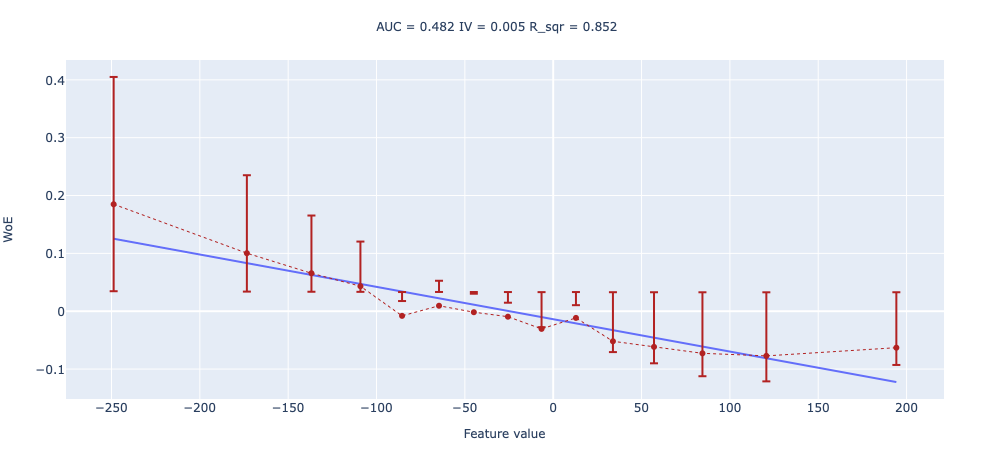

In [177]:
feature = 'feature_26'
df_train = df[df['sample_part'].isin(['train'])]
missing = np.where(df_train[feature].isna())[0]
woe_line(df_train[feature].dropna().to_numpy(), df_train['target'].drop(missing).to_numpy(), 15)

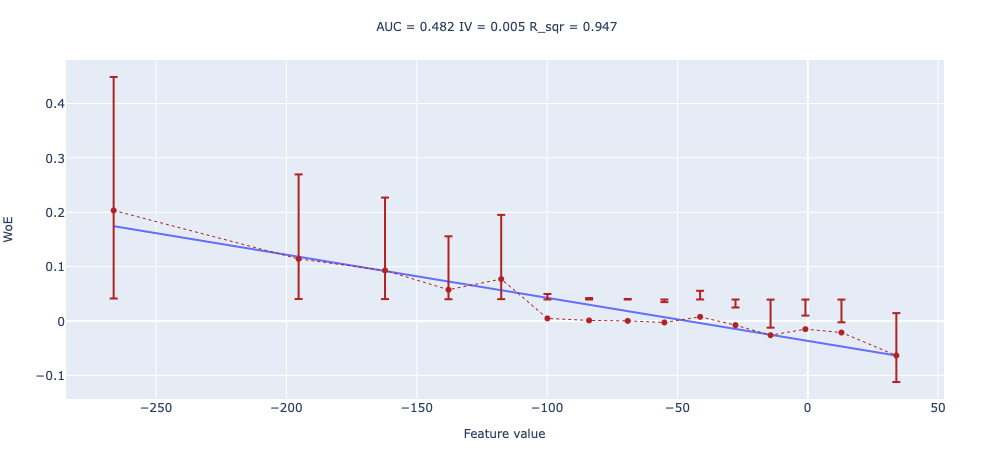

In [178]:
feature = 'feature_26'
df_train = df[df['sample_part'].isin(['train'])]
missing = np.where(df_train[feature].isna())[0]
woe_line(np.clip(df_train[feature].dropna().to_numpy(), -1000, 35), df_train['target'].drop(missing).to_numpy(), 15)

In [179]:
imputer = SimpleImputer(strategy='mean')
last_df = pd.concat([last_df, df[['feature_26']]], axis=1)
non_na_indices = last_df['feature_26'].notna()
last_df.loc[non_na_indices, 'feature_26'] = np.clip(df_for_logreg.loc[non_na_indices, 'feature_124'].to_numpy(), -1000, 35)

train_data = last_df[train_and_val_indices]
test_data = last_df[df_for_logreg_final['sample_part'] == 'test']
imputer_feature_26 = SimpleImputer(strategy='mean')
train_data['feature_26'] = imputer_feature_26.fit_transform(train_data[['feature_26']])
test_data['feature_26'] = imputer_feature_26.transform(test_data[['feature_26']])
last_df.loc[train_data.index, ['feature_26']] = train_data[['feature_26']]
last_df.loc[test_data.index, ['feature_26']] = test_data[['feature_26']]

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3664445156.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3664445156.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [180]:
X = last_df
y = df_for_logreg_final['target']
train_and_val_indices = df_for_logreg_final['sample_part'].isin(['train', 'val'])
X_train = X[train_and_val_indices]
y_train = y[train_and_val_indices]
X_test = X[df_for_logreg_final['sample_part'] == 'test']
y_test = y[df_for_logreg_final['sample_part'] == 'test']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_train_pred_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC on train set:", roc_auc_train)
print("ROC AUC on test set:", roc_auc_test)

ROC AUC on train set: 0.6190133470327366
ROC AUC on test set: 0.6185131645796826


Аук подрос. Добавим еще одну фичу

In [181]:
top_gain_ = importance_df.sort_values(by='Gain Importance', ascending=False)[:17]
top_gain_features_ = top_gain_['Feature'].to_list()[-1]

In [182]:
top_gain_features_

'feature_98'

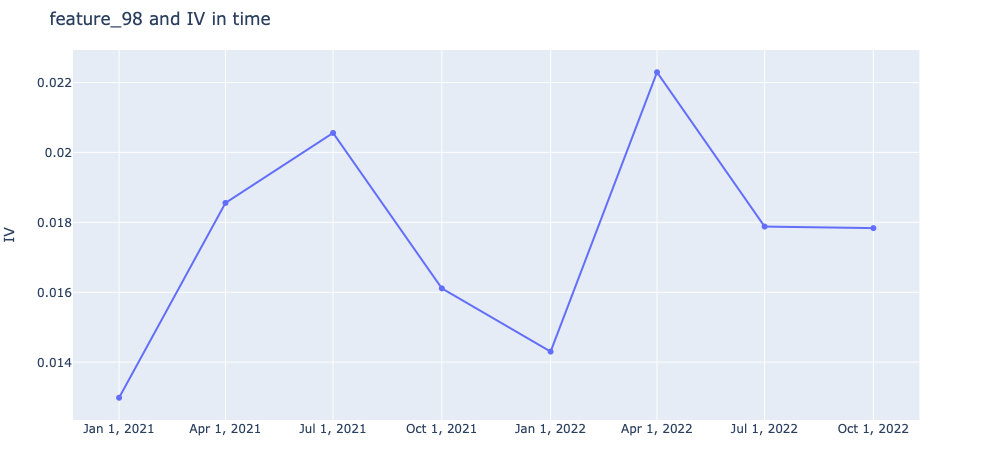

In [183]:
plot_metric_time(df['feature_98'], df['target'], df['quarter'])

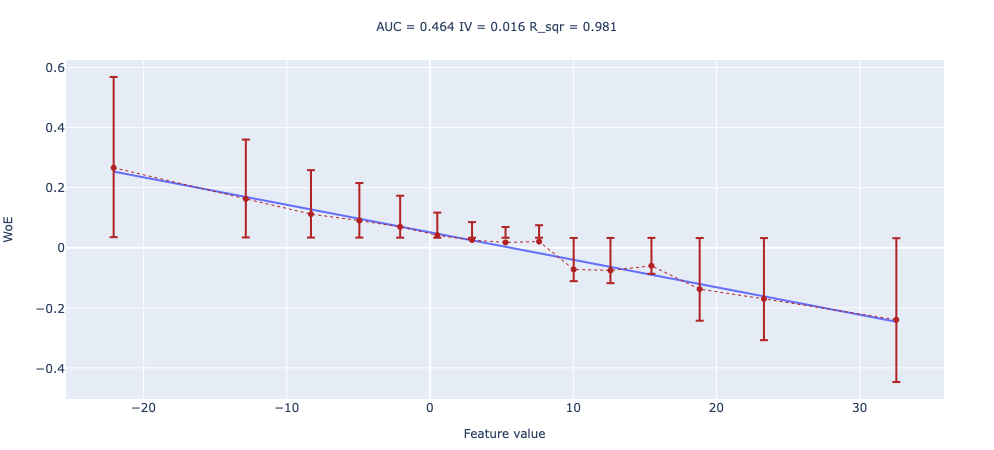

In [184]:
feature = 'feature_98'
df_train = df[df['sample_part'].isin(['train'])]
missing = np.where(df_train[feature].isna())[0]
woe_line(df_train[feature].dropna().to_numpy(), df_train['target'].drop(missing).to_numpy(), 15)

In [185]:
imputer = SimpleImputer(strategy='mean')
last_df = pd.concat([last_df, df[['feature_98']]], axis=1)
non_na_indices = last_df['feature_98'].notna()
train_data = last_df[train_and_val_indices]
test_data = last_df[df_for_logreg_final['sample_part'] == 'test']
imputer_feature_26 = SimpleImputer(strategy='mean')
train_data['feature_98'] = imputer_feature_26.fit_transform(train_data[['feature_98']])
test_data['feature_98'] = imputer_feature_26.transform(test_data[['feature_98']])
last_df.loc[train_data.index, ['feature_98']] = train_data[['feature_98']]
last_df.loc[test_data.index, ['feature_98']] = test_data[['feature_98']]

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3929716121.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3929716121.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
X = last_df
y = df_for_logreg_final['target']
train_and_val_indices = df_for_logreg_final['sample_part'].isin(['train', 'val'])
X_train = X[train_and_val_indices]
y_train = y[train_and_val_indices]
X_test = X[df_for_logreg_final['sample_part'] == 'test']
y_test = y[df_for_logreg_final['sample_part'] == 'test']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_train_pred_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC on train set:", roc_auc_train)
print("ROC AUC on test set:", roc_auc_test)

ROC AUC on train set: 0.623020959621275
ROC AUC on test set: 0.6232431861633788


Ураа!!! Победа.

**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`.

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



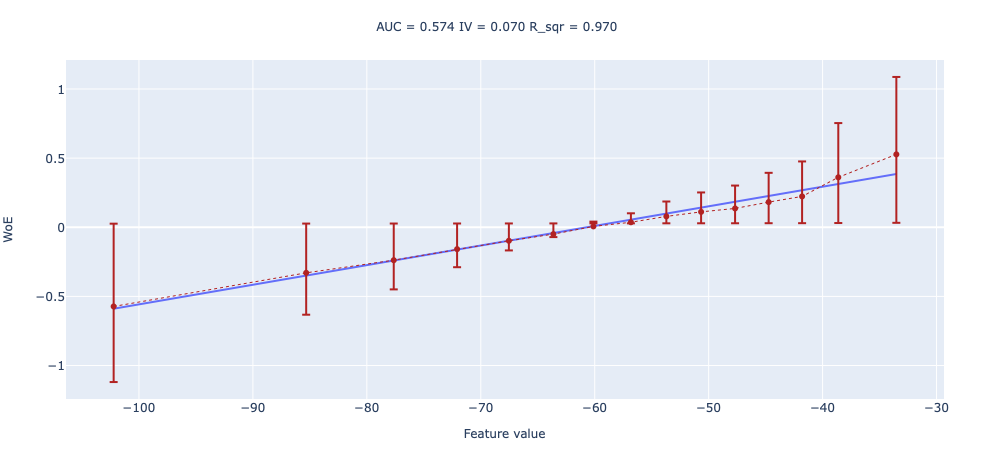

In [91]:
woe_line(logit(logreg.predict_proba(X_train)[:, 1]), y_train, 15)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



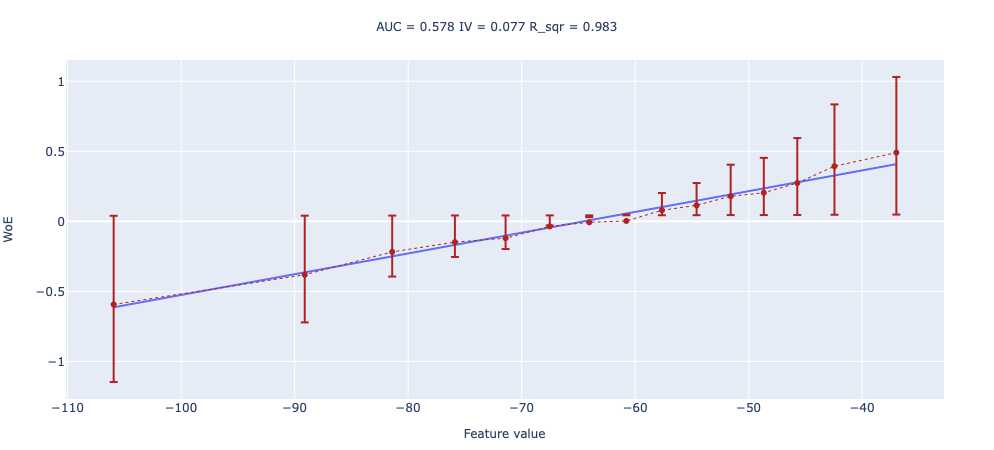

In [92]:
woe_line(logit(logreg.predict_proba(X_test)[:, 1]), y_test, 15)

In [208]:
predictions_train_df = pd.DataFrame(data=logreg.predict_proba(X_train_scaled)[:, 1], columns=['logreg_prediction_train'], index=X_train.index)

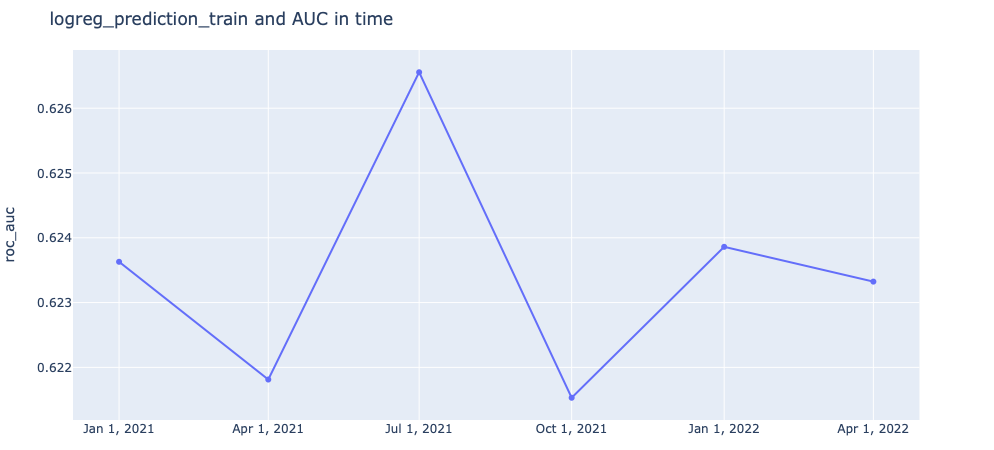

In [210]:
train_indices = X_train.index
quarter_values = df.loc[train_indices, 'quarter']
plot_metric_time(predictions_train_df['logreg_prediction_train'], y_train, quarter_values, metric = 'roc_auc')

In [211]:
predictions_df = pd.DataFrame(data=logreg.predict_proba(X_test_scaled)[:, 1], columns=['logreg_prediction_test'], index=X_test.index)

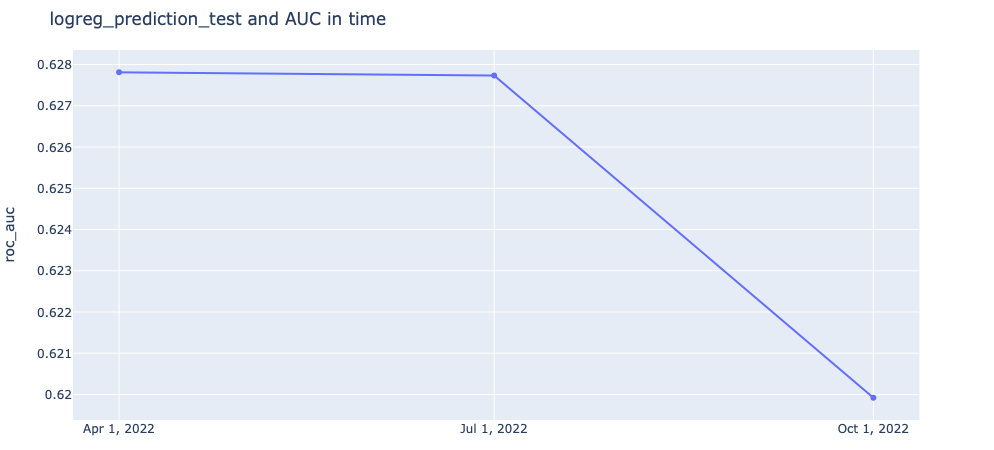

In [212]:
test_indices = X_test.index
quarter_values = df.loc[test_indices, 'quarter']
plot_metric_time(predictions_df['logreg_prediction_test'], y_test, quarter_values, metric = 'roc_auc')

Наша итоговая модель получилась вполне стабильной во времени

**Задание:** Визуализируйте важность фичей полученной линейной модели.

Text(0.5, 0, 'coefficient value')

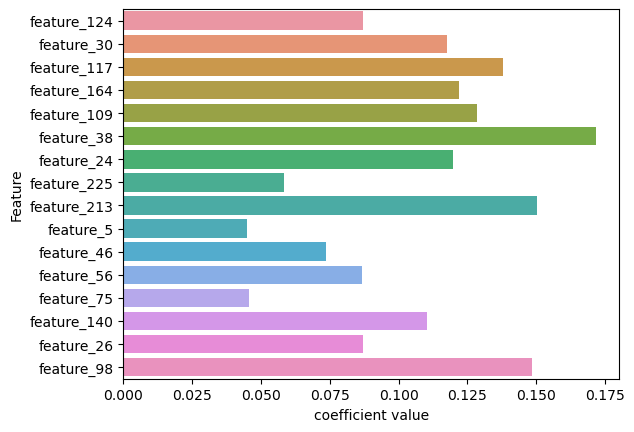

In [187]:
coefficients = logreg.coef_[0]
feature_names = X_train.columns
data = pd.DataFrame({'Feature': feature_names, 'Coefficient': abs(coefficients)})
sns.barplot(x = 'Coefficient', y = 'Feature', data = data)
plt.xlabel('coefficient value')

Заметим, что есть некоторые различия с импортансом фичей, которые давал бустинг

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

In [96]:
best_params =  {
    'learning_rate': 0.09818983307595966,
    'num_leaves': 150,
    'max_depth': 9,
    'min_child_samples': 90,
    'subsample': 0.7685890730013264,
    'colsample_bytree': 0.9380192014468047,
    'reg_alpha': 8.965716599102121,
    'reg_lambda': 7.181326555592763,
    'n_estimators': 603,
    'n_jobs': -1,
    'random_state': 42
              }
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(colsample_bytree=0.9380192014468047,
               learning_rate=0.09818983307595966, max_depth=9,
               min_child_samples=90, n_estimators=603, n_jobs=-1,
               num_leaves=150, random_state=42, reg_alpha=8.965716599102121,
               reg_lambda=7.181326555592763, subsample=0.7685890730013264)

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

In [101]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [127]:
X_train = df.loc[df['sample_part'].isin(['train', 'val']), features_optuna],
y_train = df.loc[df['sample_part'].isin(['train', 'val']), TARGET]

In [129]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train[0])

In [133]:
from boruta import BorutaPy
feat_selector = BorutaPy(clf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_train, y_train.to_numpy())
feat_selector.support_
feat_selector.ranking_

[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27182
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       8, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 7, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1],
      dtype=int32)

In [134]:
feat_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True])

In [135]:
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       8, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 7, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1],
      dtype=int32)

In [137]:
feature_ranks = list(zip(df.loc[df['sample_part'].isin(['train', 'val']), features_optuna].columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: feature_2                 Rank: 1,  Keep: True
Feature: feature_4                 Rank: 1,  Keep: True
Feature: feature_5                 Rank: 1,  Keep: True
Feature: feature_9                 Rank: 1,  Keep: True
Feature: feature_10                Rank: 1,  Keep: True
Feature: feature_12                Rank: 1,  Keep: True
Feature: feature_15                Rank: 1,  Keep: True
Feature: feature_23                Rank: 1,  Keep: True
Feature: feature_24                Rank: 1,  Keep: True
Feature: feature_26                Rank: 1,  Keep: True
Feature: feature_27                Rank: 1,  Keep: True
Feature: feature_30                Rank: 1,  Keep: True
Feature: feature_31                Rank: 3,  Keep: False
Feature: feature_32                Rank: 1,  Keep: True
Feature: feature_35                Rank: 1,  Keep: True
Feature: feature_36                Rank: 1,  Keep: True
Feature: feature_38                Rank: 1,  Keep: True
Feature: feature_39                Rank: 1,  Ke

In [138]:
X_filtered = feat_selector.transform(X_train)

In [141]:
X_filtered.shape

(350000, 55)

In [144]:
from sklearn.feature_selection import RFE
model = LGBMClassifier()
rfe = RFE(model, n_features_to_select=40)
rfe = rfe.fit(X_filtered, y_train)


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12813
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12558
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGB

In [146]:
selected_indices = [i for i, value in enumerate(rfe.support_) if value]
X_filtered_selected = X_filtered[:, selected_indices]


In [152]:
X_test = df.loc[df['sample_part'].isin(['test']), features_optuna].to_numpy()
y_test = df.loc[df['sample_part'].isin(['test']), TARGET]
X_filtered_val = feat_selector.transform(X_test)
X_filtered_val_selected = X_filtered_val[:, selected_indices] 

In [155]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'n_jobs': -1,
        'random_state': 42
    }

    clf_2 = LGBMClassifier(**params)
    clf_2.fit(
        X=X_filtered_selected,
        y=y_train
    )
    preds = clf_2.predict_proba(X_filtered_val_selected)[:, 1]
    auc_valid = roc_auc_score(
        y_true=y_test,
        y_score=preds
    )

    return auc_valid
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

[I 2024-04-05 21:39:02,818] A new study created in memory with name: no-name-c629113d-ecc4-4aa1-980b-3576e4d95044


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:39:20,984] Trial 0 finished with value: 0.6898214760965088 and parameters: {'learning_rate': 0.011350910579554783, 'num_leaves': 8, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.7728071020900187, 'colsample_bytree': 0.883740970863991, 'reg_alpha': 7.609551508221455, 'reg_lambda': 8.280102239469514, 'n_estimators': 1575}. Best is trial 0 with value: 0.6898214760965088.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:39:31,052] Trial 1 finished with value: 0.6650541974414226 and parameters: {'learning_rate': 0.001985436001756075, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 73, 'subsample': 0.7762464857909105, 'colsample_bytree': 0.6405098250952106, 'reg_alpha': 8.746339223007034, 'reg_lambda': 8.27363965573848, 'n_estimators': 357}. Best is trial 0 with value: 0.6898214760965088.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:39:44,126] Trial 2 finished with value: 0.6161131009931982 and parameters: {'learning_rate': 0.000532593657329709, 'num_leaves': 64, 'max_depth': 3, 'min_child_samples': 36, 'subsample': 0.7804723785233465, 'colsample_bytree': 0.861069817780149, 'reg_alpha': 6.614177136676613, 'reg_lambda': 7.603271926056104, 'n_estimators': 1294}. Best is trial 0 with value: 0.6898214760965088.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:39:57,450] Trial 3 finished with value: 0.7227501888803546 and parameters: {'learning_rate': 0.19316790225938404, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 52, 'subsample': 0.6976773455211438, 'colsample_bytree': 0.8243634402940683, 'reg_alpha': 6.868396663218847, 'reg_lambda': 5.405146783420692, 'n_estimators': 1008}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-04-05 21:40:07,342] Trial 4 finished with value: 0.703588627882046 and parameters: {'learning_rate': 0.7515264531455502, 'num_leaves': 12, 'max_depth': 3, 'min_child_samples': 78, 'subsample': 0.6958172349679268, 'colsample_bytree': 0.8276088724106747, 'reg_alpha': 5.052618720410136, 'reg_lambda': 3.642185474435381, 'n_estimators': 1082}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:40:25,870] Trial 5 finished with value: 0.704707663842353 and parameters: {'learning_rate': 0.009993622028703101, 'num_leaves': 30, 'max_depth': 6, 'min_child_samples': 96, 'subsample': 0.9439414983145864, 'colsample_bytree': 0.7681214853736625, 'reg_alpha': 3.691270217809363, 'reg_lambda': 1.6797051697212606, 'n_estimators': 1157}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:40:58,164] Trial 6 finished with value: 0.7045245246601735 and parameters: {'learning_rate': 0.2862699502600964, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.9783784538383342, 'colsample_bytree': 0.7329226162119084, 'reg_alpha': 0.9294016234404157, 'reg_lambda': 2.5983277600885533, 'n_estimators': 1766}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:41:11,807] Trial 7 finished with value: 0.6255812926636245 and parameters: {'learning_rate': 0.0001697632100264769, 'num_leaves': 175, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.6725465944133464, 'colsample_bytree': 0.8097344502281458, 'reg_alpha': 4.992880556847278, 'reg_lambda': 6.9335063425073304, 'n_estimators': 757}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:41:20,082] Trial 8 finished with value: 0.6209417907943219 and parameters: {'learning_rate': 0.0008283569031950782, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 82, 'subsample': 0.8609380699752684, 'colsample_bytree': 0.988905877142084, 'reg_alpha': 2.762859423815719, 'reg_lambda': 7.665840397546267, 'n_estimators': 587}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:41:29,045] Trial 9 finished with value: 0.6195663319261031 and parameters: {'learning_rate': 0.0008732850194909023, 'num_leaves': 15, 'max_depth': 3, 'min_child_samples': 77, 'subsample': 0.7595276016358703, 'colsample_bytree': 0.8293418791637112, 'reg_alpha': 4.697899128665472, 'reg_lambda': 1.8445771850425385, 'n_estimators': 947}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 21:41:32,832] Trial 10 finished with value: 0.7134811558929708 and parameters: {'learning_rate': 0.07997145889928853, 'num_leaves': 235, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.5272402872653393, 'colsample_bytree': 0.5208683104075579, 'reg_alpha': 9.85807498855797, 'reg_lambda': 4.98706235191794, 'n_estimators': 98}. Best is trial 3 with value: 0.7227501888803546.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:41:37,819] Trial 11 finished with value: 0.7236609300815864 and parameters: {'learning_rate': 0.10853354070939121, 'num_leaves': 252, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.5073865707306344, 'colsample_bytree': 0.5140270139304465, 'reg_alpha': 9.517549935733973, 'reg_lambda': 5.289887573381909, 'n_estimators': 168}. Best is trial 11 with value: 0.7236609300815864.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:41:42,843] Trial 12 finished with value: 0.7187464355630674 and parameters: {'learning_rate': 0.06468135048551357, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.5294904514732961, 'colsample_bytree': 0.5537177811537258, 'reg_alpha': 7.279145319625268, 'reg_lambda': 5.380367397610635, 'n_estimators': 204}. Best is trial 11 with value: 0.7236609300815864.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:41:59,008] Trial 13 finished with value: 0.7301363913787858 and parameters: {'learning_rate': 0.0750372826089148, 'num_leaves': 182, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.5870964208667944, 'colsample_bytree': 0.6737996935842163, 'reg_alpha': 9.809791095064181, 'reg_lambda': 0.1086301592283494, 'n_estimators': 569}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:42:12,007] Trial 14 finished with value: 0.715034441716297 and parameters: {'learning_rate': 0.015671517413361265, 'num_leaves': 186, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.5970012734865948, 'colsample_bytree': 0.6275083704961988, 'reg_alpha': 9.894266638315575, 'reg_lambda': 0.13049352546872317, 'n_estimators': 518}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:42:23,651] Trial 15 finished with value: 0.725295631828899 and parameters: {'learning_rate': 0.037185282561332536, 'num_leaves': 190, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.5940375773418873, 'colsample_bytree': 0.6548165220542135, 'reg_alpha': 8.577953408148174, 'reg_lambda': 0.006573561508862014, 'n_estimators': 422}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:42:39,393] Trial 16 finished with value: 0.7268381670789841 and parameters: {'learning_rate': 0.03170211368833044, 'num_leaves': 165, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.605858360177072, 'colsample_bytree': 0.6821682162757723, 'reg_alpha': 8.375296392560768, 'reg_lambda': 0.6409489371261705, 'n_estimators': 684}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 21:43:03,626] Trial 17 finished with value: 0.6934318896488567 and parameters: {'learning_rate': 0.0031127633438011886, 'num_leaves': 143, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.603614055898222, 'colsample_bytree': 0.7115282355437268, 'reg_alpha': 8.153979309722008, 'reg_lambda': 1.1883514652738123, 'n_estimators': 787}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 21:43:29,329] Trial 18 finished with value: 0.6734185859197498 and parameters: {'learning_rate': 0.8705137297070328, 'num_leaves': 140, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.654588579822881, 'colsample_bytree': 0.6888078155686396, 'reg_alpha': 6.061736327124421, 'reg_lambda': 3.32535148120869, 'n_estimators': 711}. Best is trial 13 with value: 0.7301363913787858.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 21:44:18,325] Trial 19 finished with value: 0.7326040682986524 and parameters: {'learning_rate': 0.029149631894470725, 'num_leaves': 207, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.5690383243297665, 'colsample_bytree': 0.5863203187469881, 'reg_alpha': 8.845974881780807, 'reg_lambda': 9.86883971150057, 'n_estimators': 1353}. Best is trial 19 with value: 0.7326040682986524.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-04-05 21:44:54,788] Trial 20 finished with value: 0.7096240441005225 and parameters: {'learning_rate': 0.32319716206981036, 'num_leaves': 221, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.5570568716067034, 'colsample_bytree': 0.5855731857717611, 'reg_alpha': 1.5229538135601874, 'reg_lambda': 9.734708755922235, 'n_estimators': 1385}. Best is trial 19 with value: 0.7326040682986524.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:45:53,587] Trial 21 finished with value: 0.7329199527975524 and parameters: {'learning_rate': 0.023675766642947835, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.6331116429087853, 'colsample_bytree': 0.5967002373665379, 'reg_alpha': 8.854919139750063, 'reg_lambda': 9.753671587200422, 'n_estimators': 1835}. Best is trial 21 with value: 0.7329199527975524.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:46:54,943] Trial 22 finished with value: 0.7222740264451987 and parameters: {'learning_rate': 0.005872123105422632, 'num_leaves': 207, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.6408358341943414, 'colsample_bytree': 0.5920090458705828, 'reg_alpha': 9.357820751806894, 'reg_lambda': 9.617291677335814, 'n_estimators': 1910}. Best is trial 21 with value: 0.7329199527975524.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 21:47:48,951] Trial 23 finished with value: 0.7334118492379439 and parameters: {'learning_rate': 0.027419383734106205, 'num_leaves': 202, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.5716630319143382, 'colsample_bytree': 0.5965001212406484, 'reg_alpha': 9.021874352280292, 'reg_lambda': 9.00503792907178, 'n_estimators': 1581}. Best is trial 23 with value: 0.7334118492379439.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[W 2024-04-05 21:47:54,555] Trial 24 failed with parameters: {'learning_rate': 0.025724650182288412, 'num_leaves': 211, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7188578354957368, 'colsample_bytree': 0.5969612381977111, 'reg_alpha': 7.851408512024603, 'reg_lambda': 9.979749756260464, 'n_estimators': 1569} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/2628581254.py", line 17, in objective
    clf_2.fit(
  File "/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py", line 1142, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
                    ^^^^^^
  File "/opt/anaconda3/lib/python3.11/s

KeyboardInterrupt: 

Без потери качества получили аук 0.7334118492379439 на тесте на 40 фичах.

In [158]:
params = {'learning_rate': 0.027419383734106205, 
          'num_leaves': 202, 
          'max_depth': 9, 
          'min_child_samples': 14, 
          'subsample': 0.5716630319143382, 
          'colsample_bytree': 0.5965001212406484, 
          'reg_alpha': 9.021874352280292, 
          'reg_lambda': 9.00503792907178, 
          'n_estimators': 1581,
          'n_jobs': -1,
          'random_state': 42 
         }

In [222]:
model = LGBMClassifier()
rfe = RFE(model, n_features_to_select=20)
rfe = rfe.fit(X_filtered_selected, y_train)

[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9491
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 39
[LightGBM] [In

In [226]:
selected_indices_twice = [i for i, value in enumerate(rfe.support_) if value]
X_filtered_selected_twice = X_filtered_selected[:, selected_indices_twice]
X_filtered_val_selected_twice = X_filtered_val[:, selected_indices_twice]
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'n_jobs': -1,
        'random_state': 42
    }

    clf_3 = LGBMClassifier(**params)
    clf_3.fit(
        X=X_filtered_selected_twice,
        y=y_train
    )
    preds = clf_3.predict_proba(X_filtered_val_selected_twice)[:, 1]
    auc_valid = roc_auc_score(
        y_true=y_test,
        y_score=preds
    )

    return auc_valid
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

[I 2024-04-05 23:34:59,092] A new study created in memory with name: no-name-a38fd033-81a3-4f18-b2df-3ab80f9b5e23


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 23:35:17,025] Trial 0 finished with value: 0.49638870436982313 and parameters: {'learning_rate': 0.04661627758148022, 'num_leaves': 162, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.676270800178224, 'colsample_bytree': 0.6436812916325976, 'reg_alpha': 2.7629403951822895, 'reg_lambda': 0.8823968759686451, 'n_estimators': 1638}. Best is trial 0 with value: 0.49638870436982313.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 23:35:22,415] Trial 1 finished with value: 0.4944368836033733 and parameters: {'learning_rate': 0.09990020638406198, 'num_leaves': 130, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9404476330305116, 'colsample_bytree': 0.7258501774845594, 'reg_alpha': 8.872998565752292, 'reg_lambda': 4.577502782645171, 'n_estimators': 581}. Best is trial 0 with value: 0.49638870436982313.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-04-05 23:35:31,105] Trial 2 finished with value: 0.5014371578854149 and parameters: {'learning_rate': 0.08857303231166826, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.5450538916091607, 'colsample_bytree': 0.7897091076376774, 'reg_alpha': 0.6413748475701098, 'reg_lambda': 3.9676807711733875, 'n_estimators': 841}. Best is trial 2 with value: 0.5014371578854149.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 23:35:59,529] Trial 3 finished with value: 0.504411670959746 and parameters: {'learning_rate': 0.0005710895932147375, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5421881933179633, 'colsample_bytree': 0.5404797489298673, 'reg_alpha': 8.873326698826373, 'reg_lambda': 0.37198821067784826, 'n_estimators': 1764}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-04-05 23:36:02,518] Trial 4 finished with value: 0.5030139647043937 and parameters: {'learning_rate': 0.0763847734598714, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 98, 'subsample': 0.882163587062115, 'colsample_bytree': 0.9380079111702406, 'reg_alpha': 6.165287415519075, 'reg_lambda': 0.04406561092337835, 'n_estimators': 330}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:36:15,281] Trial 5 finished with value: 0.4984205663836965 and parameters: {'learning_rate': 0.16641077777421687, 'num_leaves': 160, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.7038271978542485, 'colsample_bytree': 0.9341431425140878, 'reg_alpha': 2.5441670069196687, 'reg_lambda': 3.16965957977677, 'n_estimators': 1983}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:36:32,130] Trial 6 finished with value: 0.4999228697497844 and parameters: {'learning_rate': 0.0010218794656310939, 'num_leaves': 132, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.7487132736007966, 'colsample_bytree': 0.7763792078813767, 'reg_alpha': 3.229114846243272, 'reg_lambda': 1.1124359964506825, 'n_estimators': 550}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:37:15,783] Trial 7 finished with value: 0.5005107602076388 and parameters: {'learning_rate': 0.00032125148063383513, 'num_leaves': 245, 'max_depth': 10, 'min_child_samples': 40, 'subsample': 0.7804068781421826, 'colsample_bytree': 0.5972733762755963, 'reg_alpha': 5.0712116783317995, 'reg_lambda': 2.5980026226541177, 'n_estimators': 1083}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:37:34,849] Trial 8 finished with value: 0.5030716218636763 and parameters: {'learning_rate': 0.000316623927721555, 'num_leaves': 162, 'max_depth': 4, 'min_child_samples': 46, 'subsample': 0.7717911163542917, 'colsample_bytree': 0.975019336780466, 'reg_alpha': 9.531402371963328, 'reg_lambda': 1.6513916932358175, 'n_estimators': 1917}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:38:22,318] Trial 9 finished with value: 0.500158344578008 and parameters: {'learning_rate': 0.00022252000261973925, 'num_leaves': 225, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.9678393166736694, 'colsample_bytree': 0.5863378808652591, 'reg_alpha': 7.673143612860755, 'reg_lambda': 6.148044822961688, 'n_estimators': 1565}. Best is trial 3 with value: 0.504411670959746.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[I 2024-04-05 23:38:31,368] Trial 10 finished with value: 0.5152648267535275 and parameters: {'learning_rate': 0.006347696317568568, 'num_leaves': 6, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.5025441349270805, 'colsample_bytree': 0.5240746926307142, 'reg_alpha': 7.300000172732438, 'reg_lambda': 9.700854725413652, 'n_estimators': 1276}. Best is trial 10 with value: 0.5152648267535275.


[LightGBM] [Info] Number of positive: 248320, number of negative: 101680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709486 -> initscore=0.892888
[LightGBM] [Info] Start training from score 0.892888


[W 2024-04-05 23:38:40,822] Trial 11 failed with parameters: {'learning_rate': 0.004579734490205159, 'num_leaves': 6, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.5118796859665422, 'colsample_bytree': 0.5063182272221346, 'reg_alpha': 7.491763315330465, 'reg_lambda': 9.996863269620144, 'n_estimators': 1296} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/sr/_b1rjnhd2_l3h0ztg76r79z00000gn/T/ipykernel_10647/3640011782.py", line 24, in objective
    preds = clf_3.predict_proba(X_filtered_val_selected_twice)[:, 1]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py", line 1208, in predict_proba
    result = super().predict(
             ^^^^^^^^^^^^^^^^
  File "/opt/ana

KeyboardInterrupt: 

Вот тут уже произошла смерть. 0.5152648267535275 это печально.